<h1>RAndom Forest Classifier<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Log-experiment-to-Neptune.ai" data-toc-modified-id="Log-experiment-to-Neptune.ai-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Log experiment to Neptune.ai</a></span></li><li><span><a href="#Chargement-des-données" data-toc-modified-id="Chargement-des-données-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Chargement des données</a></span></li><li><span><a href="#SPLITTING" data-toc-modified-id="SPLITTING-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SPLITTING</a></span></li><li><span><a href="#Métique-métier-et-scorer" data-toc-modified-id="Métique-métier-et-scorer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Métique métier et scorer</a></span><ul class="toc-item"><li><span><a href="#Scores-du-modèles-prédisant-toujours-la-classe-majoritaire" data-toc-modified-id="Scores-du-modèles-prédisant-toujours-la-classe-majoritaire-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Scores du modèles prédisant toujours la classe majoritaire</a></span></li></ul></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forest Classifier</a></span><ul class="toc-item"><li><span><a href="#Evaluation-du-modéle" data-toc-modified-id="Evaluation-du-modéle-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Evaluation du modéle</a></span></li><li><span><a href="#Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes" data-toc-modified-id="Etude-des-differentes-options-pour-rétablir-l'équilbre-entre-les-classes-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Etude des differentes options pour rétablir l'équilbre entre les classes</a></span><ul class="toc-item"><li><span><a href="#Pipeline-with-sampling--step" data-toc-modified-id="Pipeline-with-sampling--step-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Pipeline with sampling  step</a></span><ul class="toc-item"><li><span><a href="#Under-Sampling" data-toc-modified-id="Under-Sampling-6.2.1.1"><span class="toc-item-num">6.2.1.1&nbsp;&nbsp;</span>Under Sampling</a></span></li><li><span><a href="#Over-Sampling" data-toc-modified-id="Over-Sampling-6.2.1.2"><span class="toc-item-num">6.2.1.2&nbsp;&nbsp;</span>Over Sampling</a></span></li><li><span><a href="#Class-Weight-'balanced'" data-toc-modified-id="Class-Weight-'balanced'-6.2.1.3"><span class="toc-item-num">6.2.1.3&nbsp;&nbsp;</span>Class Weight 'balanced'</a></span></li></ul></li><li><span><a href="#Combinaison-des-trois-solutions-précédentes" data-toc-modified-id="Combinaison-des-trois-solutions-précédentes-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Combinaison des trois solutions précédentes</a></span></li></ul></li><li><span><a href="#Recherche-de-la-combinaison-optimale" data-toc-modified-id="Recherche-de-la-combinaison-optimale-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Recherche de la combinaison optimale</a></span></li><li><span><a href="#Meilleure-solution" data-toc-modified-id="Meilleure-solution-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Meilleure solution</a></span></li></ul></li><li><span><a href="#Récapitulatif-des-scores" data-toc-modified-id="Récapitulatif-des-scores-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Récapitulatif des scores</a></span></li><li><span><a href="#Sauvegarde-du-modèle-pour-dasboard" data-toc-modified-id="Sauvegarde-du-modèle-pour-dasboard-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Sauvegarde du modèle pour dasboard</a></span></li></ul></div>

# Imports



In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_row', 244)
pd.set_option('display.max_column', 243)
pd.set_option('display.max_colwidth', 50)

# graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go


# misc libaries
import missingno as msno
bleu = (70 / 255, 130 / 255, 180 / 255)
# import dataprep.eda as eda
#import qgrid

# File system manangement
import os
import joblib 

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 1
%aimport Functions
from Functions import plot_confusion_matrix, cv_score,evaluate_estimator, proba_distributions, feature_importance_plot

Loading functions


In [3]:
# CONSTANTS

ITERATIONS = 150

JOBS = 2

EDA = 'EDA 1-7 all features_aggregated'


LOG = True

RESUME = True
ID_RUN = 'PROJ-9'

# Log experiment to Neptune.ai

In [4]:
import neptune.new as neptune
# import neptunecontrib.monitoring.optuna as opt_utils
import neptune.new.integrations.optuna as optuna_utils
from neptune.new.types import File

if LOG:
    NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkOTQ1YmNhNS1hZDYyLTRlYzQtYWU0Zi0xMjY0Yjg1MzBiMzEifQ=="
    # log to Neptune
    if RESUME:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07',
                           run=ID_RUN) # your credentials
    else:
        run = neptune.init(api_token=NEPTUNE_API_TOKEN,
                           project='m.leroy975/Projet07') # your credentials
    
    run['sys/tags'].add(EDA)
    run['sys/tags'].add('balanced')

    neptune_callback = optuna_utils.NeptuneCallback(run,
                                                    plots_update_freq=10,
                                                    log_plot_param_importances=True)   

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/m.leroy975/Projet07/e/PROJ-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Chargement des données




In [5]:
# local run
path='FEATURES/'
features = joblib.load ( path+EDA+'.feat')

# # Kaggle run
# path='../input/projet-07/' 
# features = joblib.load ( path+EDA+'.feat')

if LOG:
    # Name and hash of experiment features
    run['Data/Version/Features'].log(EDA)
    run['Data/Version/Features hash'].log(pd.util.hash_pandas_object(features))

Vérification du chargement

<AxesSubplot:>

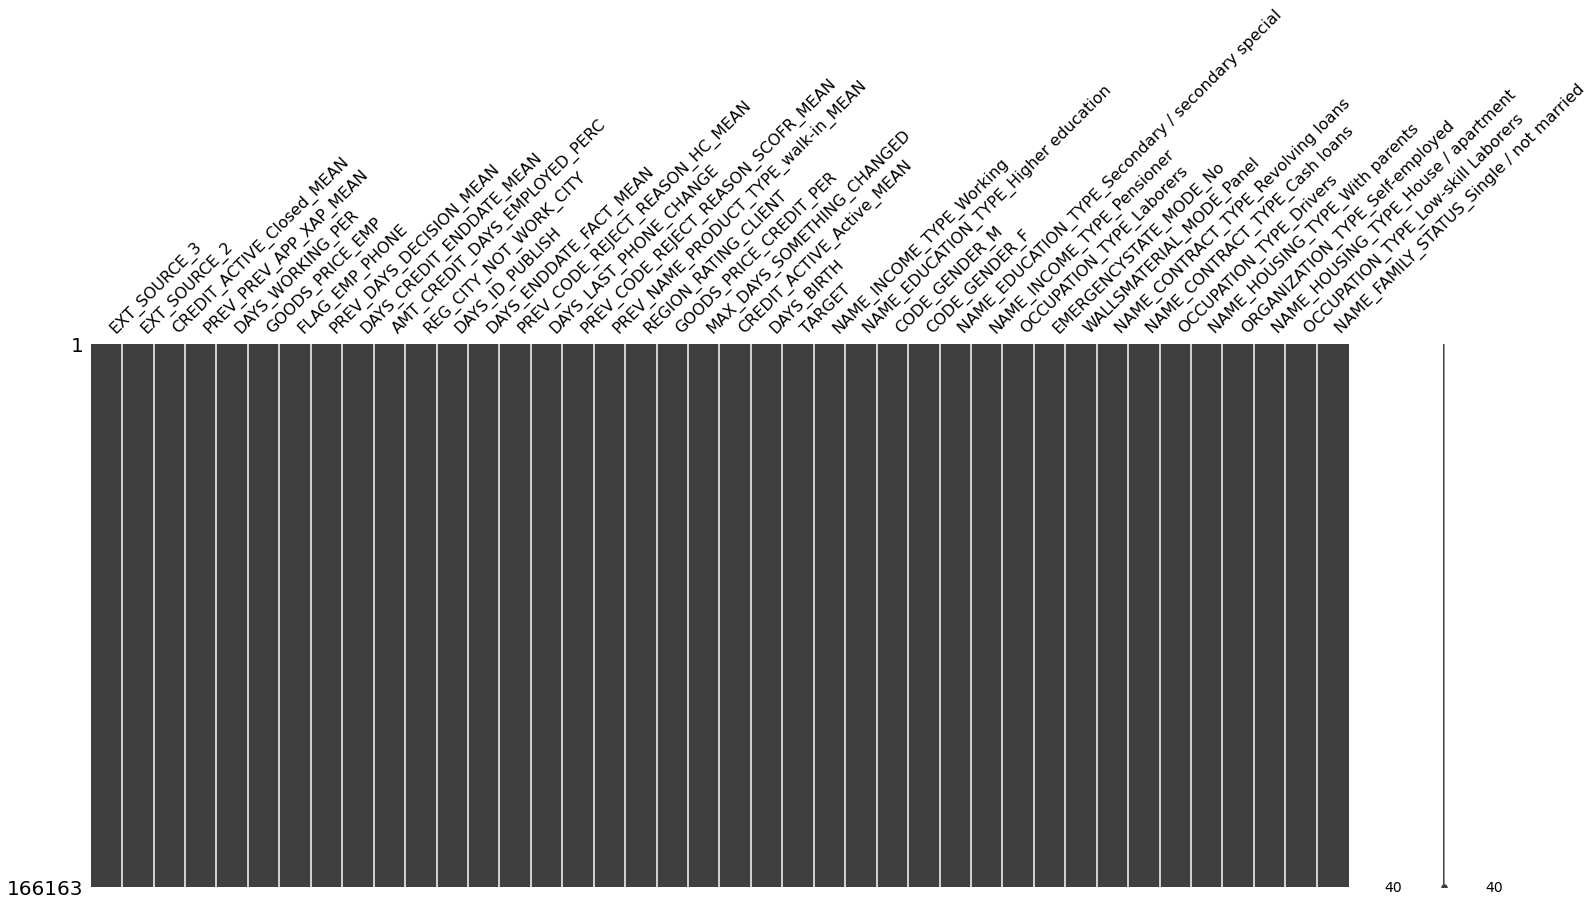

In [6]:
msno.matrix(features)

In [7]:
# Features overwiew
from collections import Counter
display(features)
print('Features shape {} x {}'.format(features.shape[0],features.shape[1]))
# TARGET ration on whole dataset
print('TARGET ratio {:.8%}'.format(features.TARGET.value_counts()[1]/features.TARGET.value_counts()[0]) )
print(Counter(features.TARGET))

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.139376,0.262949,0.750000,1.00,0.067329,0.001815,1,-606.000000,-349.000000,-0.001567,0,-2120,-697.500000,0.00,-1134.0,0.0,0.00,2,1.158397,-637.0,0.250000,-9461,1,1,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1
100004,0.729567,0.555912,1.000000,1.00,0.011814,0.001667,1,-815.000000,-488.500000,-0.001667,0,-2531,-532.500000,0.00,-815.0,0.0,0.00,2,1.000000,-225.0,0.000000,-19046,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1
100008,0.621226,0.354225,0.666667,1.00,0.093737,0.003494,1,-1192.000000,-391.333333,-0.003238,0,-477,-909.000000,0.00,-2536.0,0.0,0.00,2,1.079198,-477.0,0.333333,-16941,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0
100009,0.492060,0.724000,0.777778,1.00,0.227174,0.002244,1,-719.285714,-794.937500,-0.002005,0,-619,-1108.500000,0.00,-1562.0,0.0,0.00,2,1.118800,-619.0,0.222222,-13778,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
100010,0.540654,0.714279,0.500000,1.00,0.023820,0.000293,1,-1070.000000,-119.500000,-0.000293,1,-2379,-1138.000000,0.00,-1070.0,0.0,0.00,3,1.000000,-449.0,0.500000,-18850,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456246,0.735221,0.313334,0.666667,1.00,0.543859,0.038827,1,-897.000000,-234.666667,-0.038827,1,-4531,-1331.000000,0.00,-1516.0,0.0,0.00,2,1.000000,-4531.0,0.333333,-16063,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0
456247,0.609276,0.501221,0.727273,0.80,0.033614,0.001612,1,-1387.800000,1449.818182,-0.001155,0,-3936,-1085.000000,0.20,-2315.0,0.0,0.00,2,1.396000,-399.0,0.272727,-11870,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
456253,0.218859,0.535722,0.500000,1.00,0.529266,0.013540,1,-2380.000000,280.500000,-0.011689,1,-5150,-794.000000,0.00,-1909.0,0.0,0.00,3,1.158400,-5150.0,0.500000,-14966,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0


Features shape 166163 x 40
TARGET ratio 8.55218459%
Counter({0: 153072, 1: 13091})


In [8]:
# Descriptive Statistics of features
features.describe()

,EXT_SOURCE_3,EXT_SOURCE_2,CREDIT_ACTIVE_Closed_MEAN,PREV_PREV_APP_XAP_MEAN,DAYS_WORKING_PER,GOODS_PRICE_EMP,FLAG_EMP_PHONE,PREV_DAYS_DECISION_MEAN,DAYS_CREDIT_ENDDATE_MEAN,AMT_CREDIT_DAYS_EMPLOYED_PERC,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,DAYS_ENDDATE_FACT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,REGION_RATING_CLIENT,GOODS_PRICE_CREDIT_PER,MAX_DAYS_SOMETHING_CHANGED,CREDIT_ACTIVE_Active_MEAN,DAYS_BIRTH,TARGET,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,CODE_GENDER_M,CODE_GENDER_F,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Pensioner,OCCUPATION_TYPE_Laborers,EMERGENCYSTATE_MODE_No,WALLSMATERIAL_MODE_Panel,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_Cash loans,OCCUPATION_TYPE_Drivers,NAME_HOUSING_TYPE_With parents,ORGANIZATION_TYPE_Self-employed,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Low-skill Laborers,NAME_FAMILY_STATUS_Single / not married
count,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.00000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000,166163.000000
mean,0.510259,0.522641,0.653382,0.862464,0.167314,0.007263,0.999958,-960.526239,530.347564,-0.006515,0.269284,-2930.141831,-948.384656,0.061699,-1068.938759,0.005888,0.081658,2.055151,1.121981,-1432.243454,0.342889,-15032.930021,0.078784,0.634377,0.268225,0.363884,0.636116,0.687837,0.000048,0.217287,0.525767,0.21784,0.093137,0.906863,0.072525,0.052081,0.142926,0.883241,0.006927,0.136553
std,0.194887,0.186316,0.224895,0.197720,0.138020,0.011067,0.006490,568.589438,2591.832795,0.009935,0.443589,1485.695073,512.261883,0.133157,825.088565,0.043194,0.177448,0.499676,0.124815,1181.057628,0.223962,3555.417425,0.269402,0.481606,0.443036,0.481117,0.481117,0.463377,0.006939,0.412401,0.499337,0.41278,0.290626,0.290626,0.259356,0.222192,0.349998,0.321134,0.082940,0.343376
min,0.000527,0.000010,0.000000,0.000000,0.000042,0.000002,0.000000,-2922.000000,-28039.000000,-0.256178,0.000000,-7197.000000,-2884.000000,0.000000,-4173.000000,0.000000,0.000000,1.000000,0.150000,-6226.000000,0.000000,-25200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370650,0.411550,0.500000,0.750000,0.061776,0.001720,1.000000,-1297.000000,-711.000000,-0.007465,0.000000,-4239.000000,-1269.500000,0.000000,-1684.000000,0.000000,0.000000,2.000000,1.000000,-2094.000000,0.187500,-17721.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.537070,0.573477,0.666667,1.000000,0.130265,0.003899,1.000000,-845.375000,-197.000000,-0.003506,0.000000,-3076.000000,-916.000000,0.000000,-929.000000,0.000000,0.000000,2.000000,1.118800,-1094.000000,0.333333,-14834.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.667458,0.666053,0.800000,1.000000,0.234367,0.008310,1.000000,-512.422619,505.950000,-0.001541,1.000000,-1696.000000,-565.633333,0.000000,-376.000000,0.000000,0.083333,2.000000,1.198000,-495.000000,0.500000,-12168.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.885488,0.855000,1.000000,1.000000,0.728811,0.256178,1.000000,-2.000000,31186.000000,-0.

# SPLITTING

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(features,
                               test_size=.2,
                               random_state=42,
                               shuffle=True,
                               stratify=features.TARGET)

train_true = train.pop('TARGET')
print('train',train.shape)
print('TARGET=1 ratio on train {:.8%}'.format(train_true.value_counts()[1]/train_true.value_counts()[0]) )
test_true = test.pop('TARGET')
print('test',test.shape)
print('TARGET=1 ratio on test {:.8%}'.format(test_true.value_counts()[1]/test_true.value_counts()[0]))

train (132930, 39)
TARGET=1 ratio on train 8.55238982%
test (33233, 39)
TARGET=1 ratio on test 8.55136371%


In [10]:
if LOG:
    run['Data/Version/Train shape'].log(str(train.shape))
    run['Data/Version/Train target ratio'].log(train_true.value_counts()[1]/train_true.value_counts()[0])
    run['Data/Version/Test shape'].log(str(test.shape))
    run['Data/Version/Test target ratio'].log(test_true.value_counts()[1]/test_true.value_counts()[0])

# Métique métier et scorer

In [11]:
from sklearn.metrics import  confusion_matrix, make_scorer, roc_auc_score

# Cost weight
tn_cost = 2  ; fn_cost = -5
fp_cost = -6  ; tp_cost = 1

penalty = np.array([tn_cost,fn_cost,fp_cost,tp_cost])

# cost function
def cost(y,y_pred):
    cm = confusion_matrix(y,y_pred,normalize='true')
#     print(cm)

#     return  sum( cm.reshape(-1)*penalty)
    return  (sum( cm.reshape(-1)*penalty)+11)/14

SCORER = {'AUC' : 'roc_auc', 'COST' : make_scorer(cost)}

In [12]:
# Worst score
true =  [0,0,1,1]
preds = [1,1,0,0] 
print('Worst cost score : ',cost(true, preds))
print('Worst roc auc score : ',roc_auc_score(true, preds))

Worst cost score :  0.0
Worst roc auc score :  0.0


In [13]:
# Best score
true =  [0,0,0,1,1,1,1,0,0,0,1,0,1]
preds = [0,0,0,1,1,1,1,0,0,0,1,0,1] 
print('Best cost score : ',cost(true, preds))
print('Best roc auc score : ',roc_auc_score(true, preds))

Best cost score :  1.0
Best roc auc score :  1.0


## Scores du modèles prédisant toujours la classe majoritaire

In [14]:
cost(train_true, [0]*len(train_true))

0.5

In [15]:
roc_auc_score(train_true, [0]*len(train_true))

0.5

# Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

MODEL = RandomForestClassifier(random_state=42, n_jobs=-1)
if LOG:
    # Name and hash of experiment features
    run['Modele/Name'] = 'RandomForest Classifier'
    run['sys/description'] = 'RandomForest'

## Evaluation du modéle 

Pipeline : 

    * min max scaler [0;1]
    * modèle
    
Scores sur 5 cross validations    

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

Class balance on fitting model step : Counter({0: 122457, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122457
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132930
   macro avg       1.00      1.00      1.00    132930
weighted avg       1.00      1.00      1.00    132930

 Scores  on train : {'COST': 0.5015238363124072, 'AUC': 0.7141803466993045}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30615
           1       0.57      0.00      0.01      2618

    accuracy                           0.92     33233
   macro avg       0.74      0.50      0.48     33233
weighted avg       0.89      0.92      0.88     33233

 Scores  on test : {'COST': 0.5023194926716845}


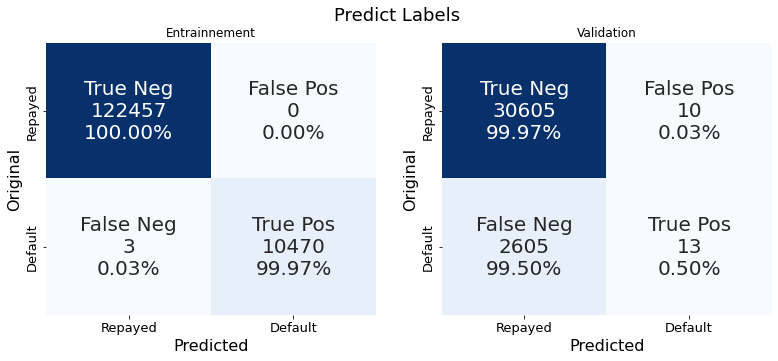

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline 

from collections import Counter


pipe = Pipeline([ 
                 ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                 ('model', MODEL)
                ])

# fit pipeline on train
pipe.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Out of bag]/Classe efectives'] = str(Counter(train_true))
    
# print evaluation summary
evaluate_estimator(pipe,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Out of bag]/'))

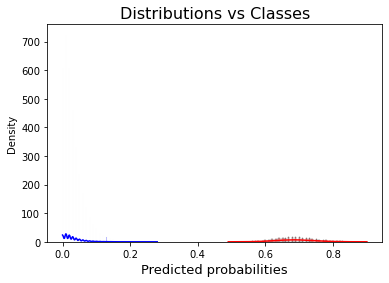

In [19]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Train')
                   )

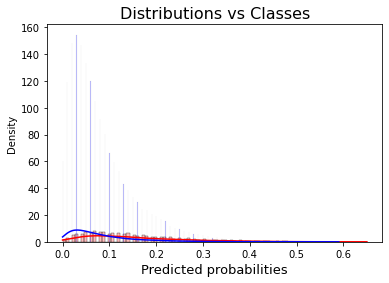

In [20]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Out of bag]/Test')
                   )

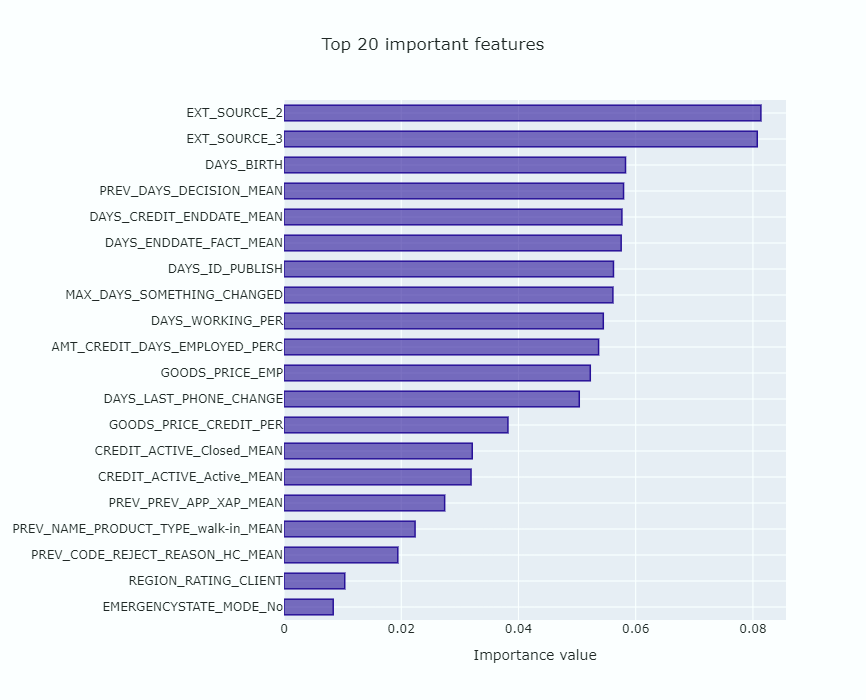

In [21]:
# Feature importance
feature_importance_plot(pipe[-1].feature_importances_,train,(LOG,run,'Modele/[Out of bag]/'))

## Etude des differentes options pour rétablir l'équilbre entre les classes

### Pipeline with sampling  step

In [22]:
pipe_samplers = Pipeline([ 
                          ('over' , None),
                          ('under' , None),
                          ('scaler' , MinMaxScaler(feature_range=(0, 1))),
                          
                          ('model', MODEL)
                     ]
                    )

#### Under Sampling

Pipeline(steps=[('over', None), ('under', RandomUnderSampler(random_state=42)),
                ('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

Class balance on fitting model step : Counter({0: 10473, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      0.71      0.83    122457
           1       0.23      1.00      0.37     10473

    accuracy                           0.73    132930
   macro avg       0.61      0.85      0.60    132930
weighted avg       0.94      0.73      0.79    132930

 Scores  on train : {'COST': 0.6717123608344442, 'AUC': 0.7299855464014633}
TEST
               precision    recall  f1-score   support

           0       0.96      0.68      0.80     30615
           1       0.15      0.66      0.25      2618

    accuracy                           0.68     33233
   macro avg       0.55      0.67      0.52     33233
weighted avg       0.90      0.68      0.76     33233

 Scores  on test : {'COST': 0.6701939374475906}


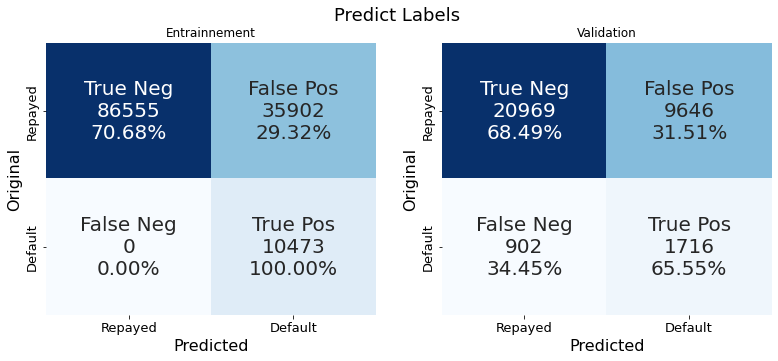

In [23]:
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler 

pipe_under = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomUnderSampler
pipe_under.set_params(**{'under': RandomUnderSampler (random_state=42) })
display(pipe_under)

# fit pipeline on train
pipe_under.fit(train, train_true)


# Count effective classes
sampled_train_true = pipe_under[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Under]/Classe efectives'] = str(Counter(sampled_train_true))


evaluate_estimator(pipe_under,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Under]/')
                  )

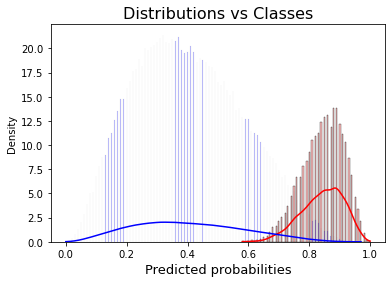

In [24]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_under.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Under]/Train')
                   )

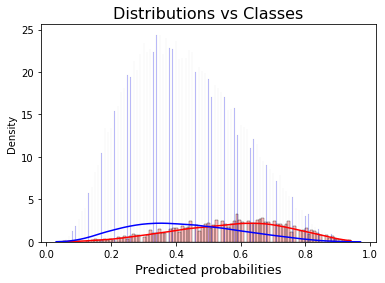

In [25]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_under.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Under]/Test')
                   )

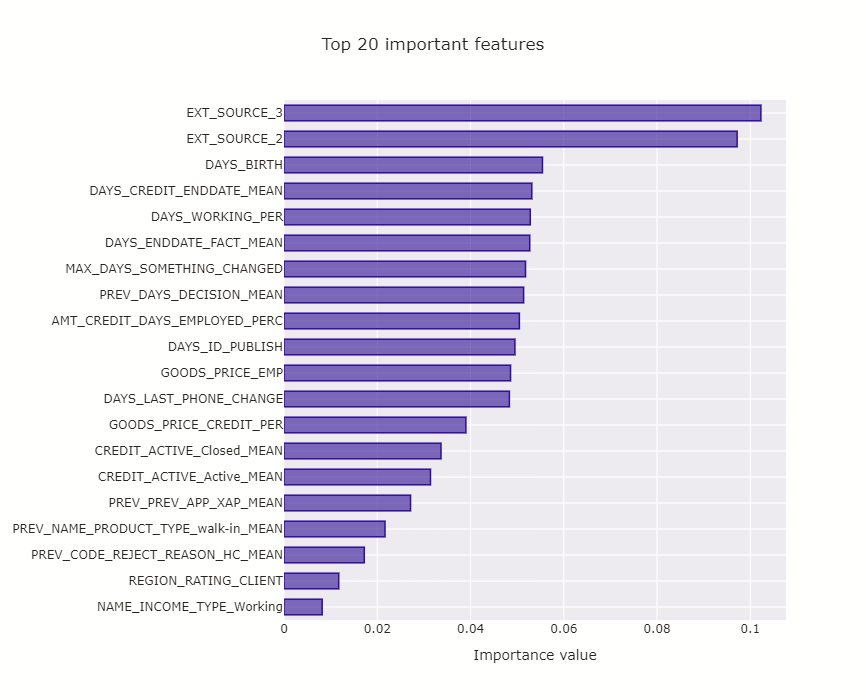

In [26]:
# Feautres importance for model
feature_importance_plot(pipe_under[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Under]/')
                       )

#### Over Sampling

Pipeline(steps=[('over', RandomOverSampler(random_state=42)), ('under', None),
                ('scaler', MinMaxScaler()),
                ('model', RandomForestClassifier(n_jobs=-1, random_state=42))])

Class balance on fitting model step : Counter({0: 122457, 1: 122457})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122457
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132930
   macro avg       1.00      1.00      1.00    132930
weighted avg       1.00      1.00      1.00    132930

 Scores  on train : {'COST': 0.5058835943973764, 'AUC': 0.7217986613628882}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30615
           1       0.41      0.01      0.03      2618

    accuracy                           0.92     33233
   macro avg       0.67      0.51      0.49     33233
weighted avg       0.88      0.92      0.89     33233

 Scores  on test : {'COST': 0.5063591959433099}


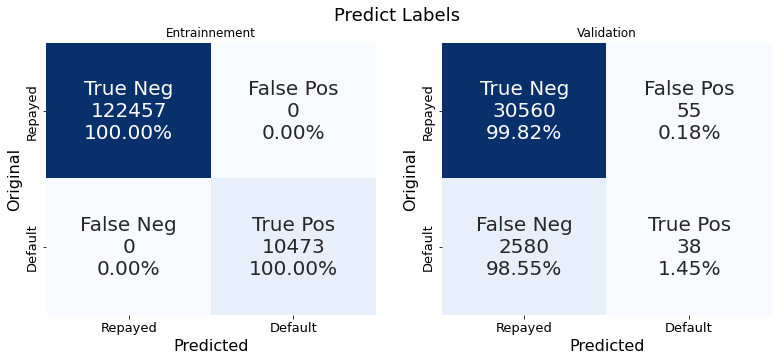

In [27]:
from imblearn.over_sampling import RandomOverSampler 

pipe_over = clone(pipe_samplers)

# set pipeline set 'sampler' to RandomOverSampler
pipe_over.set_params(**{'over': RandomOverSampler (random_state=42) })
display(pipe_over)

# fit pipeline on train
pipe_over.fit(train, train_true)

# Count effective classes
sampled_train_true = [0,1]*train_true.value_counts()[0] #pipe_over[0:2].fit_resample(train,train_true)[1]
print('Class balance on fitting model step : %s' % Counter(sampled_train_true))
if LOG:
    run['Modele/[Over]/Classe efectives'] = str(Counter(sampled_train_true))

# evaluate
evaluate_estimator(pipe_over,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Over]/')
                  )

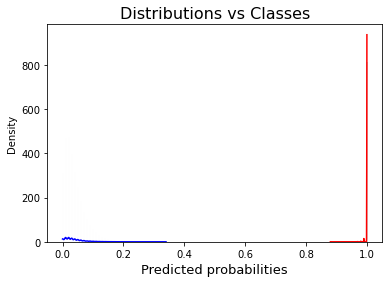

In [28]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_over.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Over]/Train')
                   )

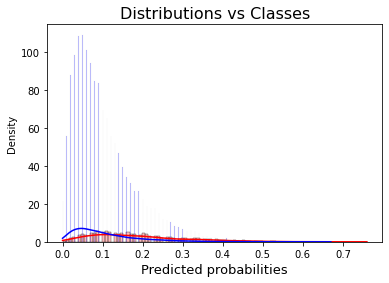

In [29]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_over.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Over]/Test')
                   )

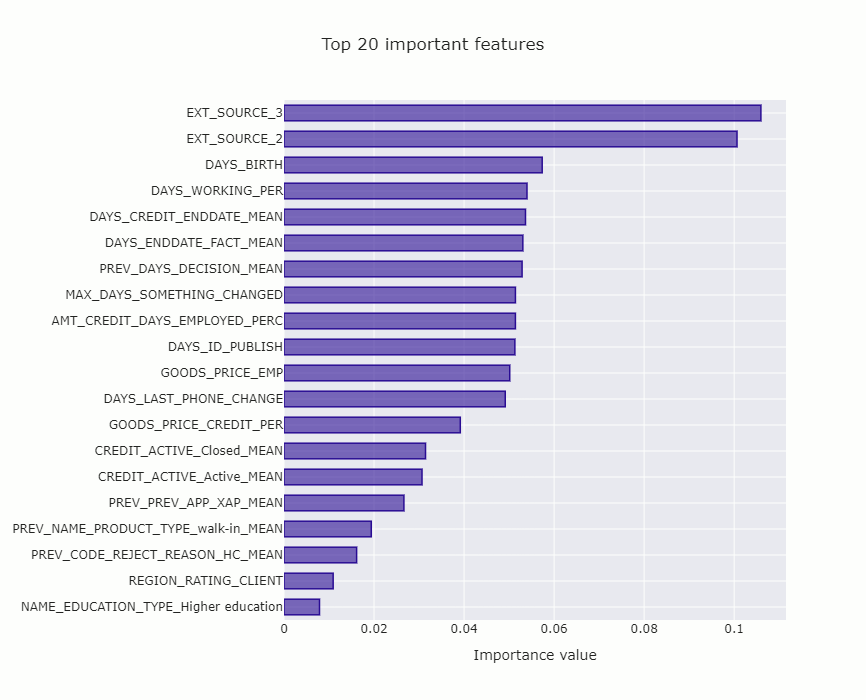

In [30]:
# Feautres importance for model
feature_importance_plot(pipe_over[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Over]/')
                       )

#### Class Weight 'balanced'

Pipeline(steps=[('over', None), ('under', None), ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Class balance on fitting model step : Counter({0: 122457, 1: 10473})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122457
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132930
   macro avg       1.00      1.00      1.00    132930
weighted avg       1.00      1.00      1.00    132930

 Scores  on train : {'COST': 0.5010000630018712, 'AUC': 0.7174236852083895}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30615
           1       0.62      0.00      0.00      2618

    accuracy                           0.92     33233
   macro avg       0.77      0.50      0.48     33233
weighted avg       0.90      0.92      0.88     33233

 Scores  on test : {'COST': 0.5009059318351189}


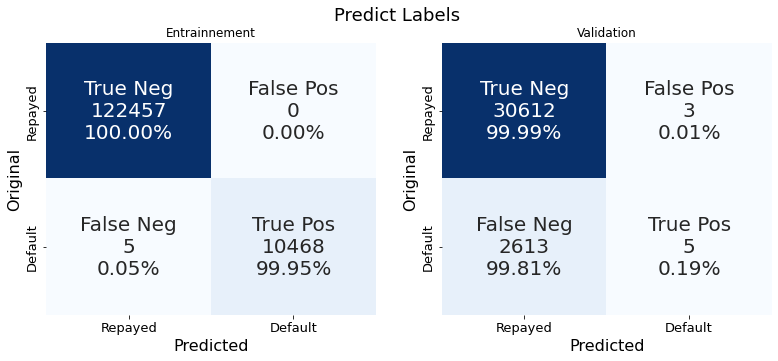

In [31]:

pipe_balance = clone(pipe_samplers)

# fit pipeline on train with sample_weight
pipe_balance.set_params(**{'model__class_weight': 'balanced'})
display(pipe_balance)

# fit pipeline on train
pipe_balance.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(train_true))
if LOG:
    run['Modele/[Balance]/Classe efectives'] = str(Counter(train_true))

# evaluate
evaluate_estimator(pipe_balance,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Balance]/')
                  )


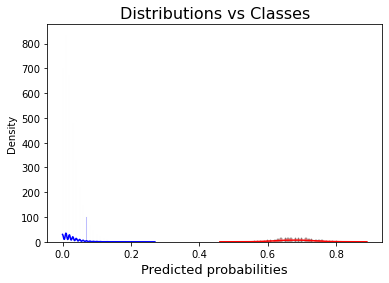

In [32]:
# Distribution of prediction probabilities versus classes on train
train_predicted_probas = pipe_balance.predict_proba(train)
proba_distributions(train_true,
                    train_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Train')
                   )

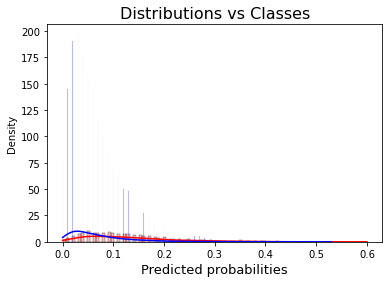

In [33]:
# Distribution of prediction probabilities versus classes on test
test_predicted_probas = pipe_balance.predict_proba(test)
proba_distributions(test_true,
                    test_predicted_probas,
                    (LOG,run,'Modele/[Balance]/Test')
                   )

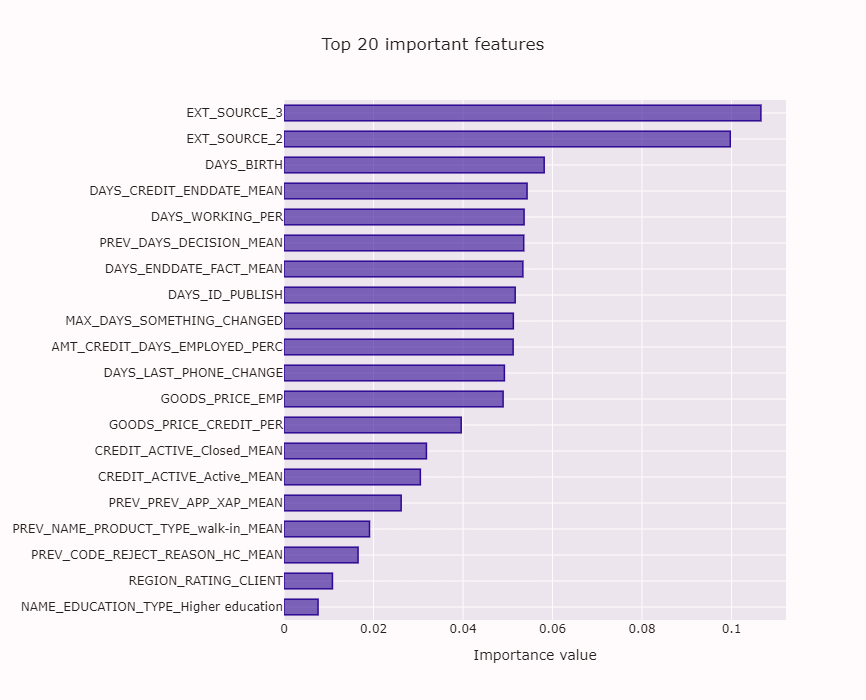

In [34]:
# Feautres importance for model
feature_importance_plot(pipe_balance[-1].feature_importances_,
                        train,
                        (LOG,run,'Modele/[Balance]/')
                       )

### Combinaison des trois solutions précédentes

Pour rééquilibrer les classes:

    * undersampler classe majoritaire en ne prenant que 75% des samples de cette classe
    
    * oversampler classe ninoritaire en duplicant 25% des samples de cette classe
    
    * pondérer les individus en fonction de leur appartenance à majority ou miority (option 'balanced' du modèle)





Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy=0.10690487273083613)),
                ('under',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=0.1425398303077815)),
                ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

Class balance on fitting model step : Counter({0: 91840, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122457
           1       1.00      1.00      1.00     10473

    accuracy                           1.00    132930
   macro avg       1.00      1.00      1.00    132930
weighted avg       1.00      1.00      1.00    132930

 Scores  on train : {'COST': 0.5037533795019906, 'AUC': 0.7204558649532731}
TEST
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     30615
           1       0.48      0.01      0.02      2618

    accuracy                           0.92     33233
   macro avg       0.70      0.50      0.49     33233
weighted avg       0.89      0.92      0.88     33233

 Scores  on test : {'COST': 0.504508330435644}


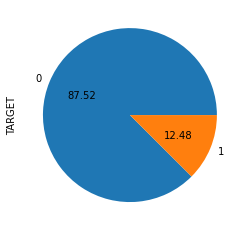

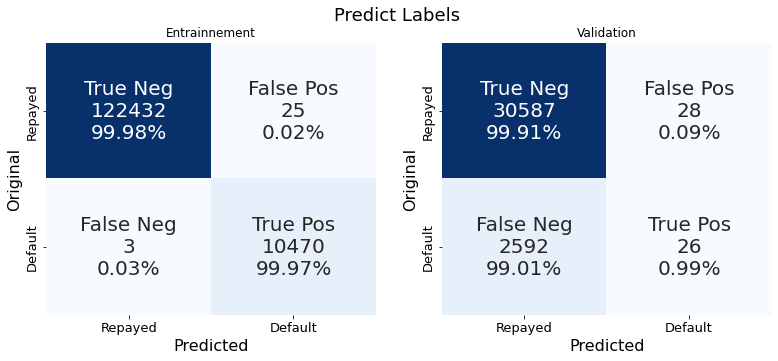

In [35]:
# Initial ratio between classes
ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]

# Sampling factors
over = .25
under = .75
# Compute strategy for samplers
over_strategy = ratio_initial *(1 + over)
under_strategy = ratio_initial *(1 + over)/( under)

# set pipeline over and under 
pipe_samplers.set_params(**{'over': RandomOverSampler (random_state=42,sampling_strategy=over_strategy),
                        'under': RandomUnderSampler (random_state=42,sampling_strategy=under_strategy),
                        'model__class_weight': 'balanced'})
display(pipe_samplers)

# fit pipeline on train
pipe_samplers.fit(train, train_true)

# Count effective classes
sampled_train_true = pipe_samplers[0:2].fit_resample(train,train_true)[1]

print('Class balance on fitting model step : %s' % Counter(sampled_train_true))

sampled_train_true.value_counts().plot.pie(autopct='%.2f')
if LOG:
    run['Modele/[Samplers & Weight]/Classe efectives'] = str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))


# evaluate
evaluate_estimator(pipe_samplers,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Samplers & Weight]/'))

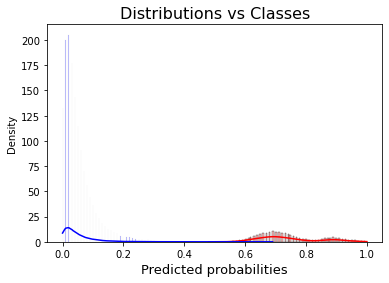

In [36]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_samplers.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Train'))

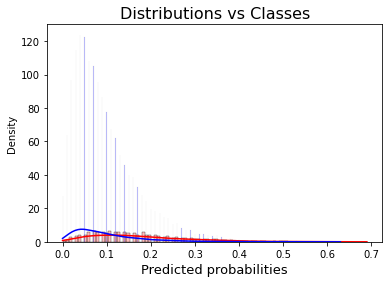

In [37]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_samplers.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Samplers & Weight]/Test'))

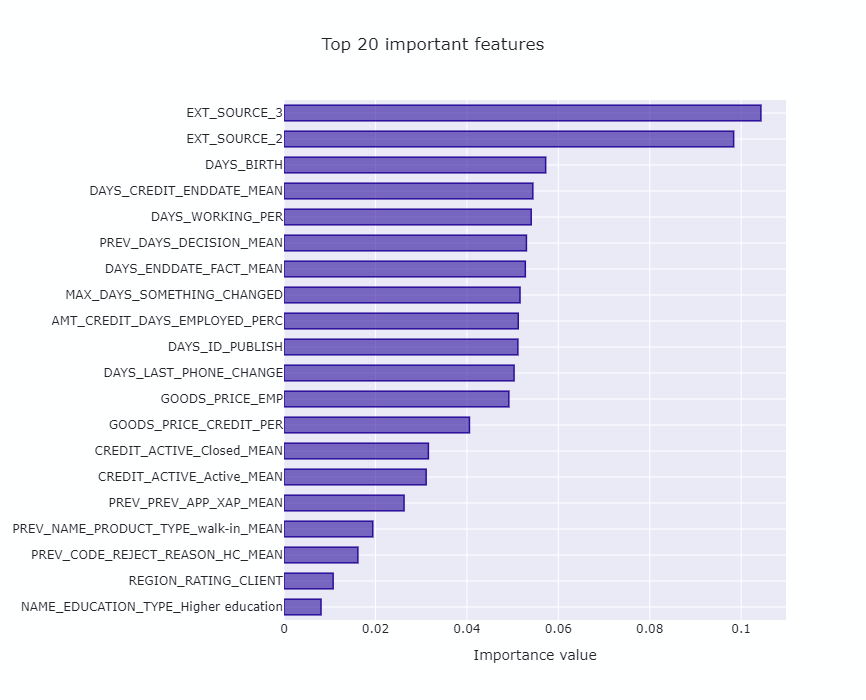

In [38]:
feature_importance_plot(pipe_samplers[-1].feature_importances_,train,(LOG,run,'Modele/[Samplers & Weight]/'))

Le modèle overfit .

Grid search pour déterminer la meilleure approche

## Recherche de la combinaison optimale

In [39]:
from sklearn.preprocessing import StandardScaler  # MODIFIE
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from joblib import Memory
from shutil import rmtree
# Create a temporary folder to store the transformers of the pipeline
# location = 'cachedir1'
# memory = Memory(location=location, verbose=0)


# Reset pipeline parameters
pipe_optim = Pipeline([ 
                            ('over' , RandomOverSampler (random_state=42)),
                            ('under' , RandomUnderSampler(random_state=42)),
                            ('scaler' , None),

                            ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
                        ],
#                         memory=memory
                       )

In [40]:
pipe_optim.get_params()

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', RandomForestClassifier(n_jobs=-1, random_state=42))],
 'verbose': False,
 'over': RandomOverSampler(random_state=42),
 'under': RandomUnderSampler(random_state=42),
 'scaler': None,
 'model': RandomForestClassifier(n_jobs=-1, random_state=42),
 'over__random_state': 42,
 'over__sampling_strategy': 'auto',
 'over__shrinkage': None,
 'under__random_state': 42,
 'under__replacement': False,
 'under__sampling_strategy': 'auto',
 'model__bootstrap': True,
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__max_leaf_nodes': None,
 'model__max_samples': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_impurity_split': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'mode

In [41]:
### fonction to maximize
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.base import clone

ratio_initial = train_true.value_counts()[1]/train_true.value_counts()[0]
std = StandardScaler()
mmx = MinMaxScaler(feature_range=(0, 1))
qt = QuantileTransformer(n_quantiles=10000,
                        output_distribution='normal',
                        ignore_implicit_zeros=False,
                        subsample=100000,
                        random_state=42)
rob = RobustScaler(with_centering=True,
                        with_scaling=True,
                        quantile_range=(25.0, 75.0),
                        copy=True,
                        unit_variance=True)
pwt = PowerTransformer(method='yeo-johnson',
                     standardize=True,
                     copy=True)

def Opt_search(trial):
    # the function gets a set of variable parameters in "param"
    # we use theses params to set pipeline params
    
    # Initialize params
    params = {}
    pipe = clone(pipe_optim)
    
    # Variance space
#     params['variance__threshold'] = trial.suggest_float('variance', 0, .1)  # MODIFIE
    
    # ratios for samplers
    o_r = trial.suggest_float('ratio_over', 0, 1)
    u_r = trial.suggest_float('ratio_under', .5, 1)
    
    #over sampling
    params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)
    
    # under sampling
    params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r) 
    
    # sample weight
#     x = trial.suggest_float('weight',0.5,0.99)  # MODIFIE
#     params['model__class_weight'] = {0 : 1-x, 1 : x}
    params['model__class_weight'] = 'balanced'
        
    # Scaller space
    scaler_name = trial.suggest_categorical('scaller name', ['StandardScaler',
                                                             'MinMaxScaler',
                                                             'QuantileTransformer',
                                                             'RobustScaler',
                                                             'PowerTransformer'
                                                            ])
    if scaler_name == 'MinMaxScaler':
        params['scaler'] = mmx
                                             
    elif scaler_name == 'StandardScaler':
        params['scaler'] =  std   
        
    elif scaler_name == 'QuantileTransformer':
        params['scaler'] =  qt
        
    elif scaler_name == 'RobustScaler':
        params['scaler'] =  rob
        
    elif scaler_name == 'PowerTransformer':
        params['scaler'] =  pwt
        
    # Random Forest space       
    params['model__max_depth'] = trial.suggest_int('model__max_depth',2,10)
    params['model__n_estimators'] = trial.suggest_int('model__n_estimators',10,200)
    params['model__criterion'] = trial.suggest_categorical('model__criterion',['gini','entropy'])
    params['model__max_features'] = trial.suggest_categorical('model__max_features',['sqrt','log2','auto'])
#     params['model__warm_start'] = trial.suggest_categorical('model__warm_start',[False,True])
    params['model__oob_score'] = trial.suggest_categorical('model__oob_score',[False, True])
            
#     print(params)
    
    # we use theses params to set pipeline params
    pipe.set_params(**params)
    
    #     print(pipe.get_params(deep=False))
               
    # score
    score = cross_validate(pipe,
                           train,
                           train_true,
                           scoring=SCORER,
                           n_jobs=1,
                           cv=cv)
    
    print('> cv cost score mean: %.4f (\u00B1 %.4f) <> roc auc score mean: %.4f (\u00B1 %.4f) < ' % (
                                                                                        score['test_COST'].mean(),
                                                                                        score['test_COST'].std(),
                                                                                        score['test_AUC'].mean(),
                                                                                        score['test_AUC'].std()
                                                                                       )
         )
    
    if LOG:
        run['AUC'].log(score['test_AUC'].mean())
        run['COST'].log(score['test_COST'].mean())
        
    return score['test_COST'].mean()

In [42]:
# Verify pipeline before optimize
pipe_optim.get_params(deep=False)

{'memory': None,
 'steps': [('over', RandomOverSampler(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('scaler', None),
  ('model', RandomForestClassifier(n_jobs=-1, random_state=42))],
 'verbose': False}

In [43]:
# Create study the first time or append existing
import os.path
from os import path
import optuna
from optuna.samplers import TPESampler


# Studiing n_iter times
n_iter = ITERATIONS

# Optimize
if LOG and RESUME:
    # Load Optuna Study from the Neptune Run
    study = optuna_utils.load_study_from_run(run)  
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
elif LOG and not RESUME:
    name = 'RFC '+EDA
    study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 50)
                                   )
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS, callbacks=[neptune_callback])
    
else:
    # Local run
    save_path = 'Studies/'
    name =save_path+'NEWRUN_rfc_'+EDA+'reg_COST1'
    file_name = name+'.study'

    if path.exists(file_name):
        # load study
        study = joblib.load(file_name)
        print('Loading {}'.format(file_name))

        # Load Optuna Study from the Neptune Run
    #     study = optuna_utils.load_study_from_run(run)

    else:
        # Otherwise create study
        print('Creating a new study named {}'.format(name))
        study = optuna.create_study(study_name=name,
                                    direction='maximize',

                                    sampler=TPESampler(n_startup_trials= 10)
                                   )
        
    study.optimize(Opt_search, n_trials=n_iter, n_jobs=JOBS)

# # save the sutdy 
# joblib.dump(study, file_name)

# print best results
print('Best custom_score = {} for :\n'.format(study.best_value))

for key, value in study.best_params.items():
    print("    {}: {}".format(key, value))

[I 2021-07-13 11:48:43,100] Trial 140 finished with value: 0.6744877086738592 and parameters: {'ratio_over': 0.8414854740381639, 'ratio_under': 0.6571305441176267, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 121, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6745 (± 0.0033) <> roc auc score mean: 0.7373 (± 0.0046) < 


[I 2021-07-13 11:48:56,274] Trial 141 finished with value: 0.6753546727761488 and parameters: {'ratio_over': 0.8391834881472853, 'ratio_under': 0.6675599087754419, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 119, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6754 (± 0.0017) <> roc auc score mean: 0.7377 (± 0.0043) < 


[I 2021-07-13 11:50:09,814] Trial 143 finished with value: 0.6746898281192524 and parameters: {'ratio_over': 0.8471978901957394, 'ratio_under': 0.6365963397656784, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 113, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6747 (± 0.0032) <> roc auc score mean: 0.7374 (± 0.0048) < 


[I 2021-07-13 11:50:11,945] Trial 142 finished with value: 0.6704158729831973 and parameters: {'ratio_over': 0.9170335189820009, 'ratio_under': 0.6304370612228692, 'scaller name': 'PowerTransformer', 'model__max_depth': 9, 'model__n_estimators': 132, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6704 (± 0.0035) <> roc auc score mean: 0.7374 (± 0.0044) < 


Experiencing connection interruptions. Will try to reestablish communication with Neptune.
Communication with Neptune restored!
[I 2021-07-13 11:51:23,663] Trial 145 finished with value: 0.6749365365261376 and parameters: {'ratio_over': 0.8054375832865416, 'ratio_under': 0.643794614001387, 'scaller name': 'PowerTransformer', 'model__max_depth': 6, 'model__n_estimators': 119, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6749 (± 0.0032) <> roc auc score mean: 0.7359 (± 0.0048) < 


[I 2021-07-13 11:51:23,955] Trial 144 finished with value: 0.6746506974518939 and parameters: {'ratio_over': 0.8005862148104032, 'ratio_under': 0.6795492255560202, 'scaller name': 'PowerTransformer', 'model__max_depth': 6, 'model__n_estimators': 119, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6747 (± 0.0025) <> roc auc score mean: 0.7357 (± 0.0046) < 


[I 2021-07-13 11:52:32,692] Trial 147 finished with value: 0.6736522261494553 and parameters: {'ratio_over': 0.8586126789103294, 'ratio_under': 0.6220880338044167, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 103, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6737 (± 0.0022) <> roc auc score mean: 0.7369 (± 0.0045) < 


[I 2021-07-13 11:52:36,306] Trial 146 finished with value: 0.6742654552039624 and parameters: {'ratio_over': 0.8638283246486826, 'ratio_under': 0.66892032067922, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 118, 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6743 (± 0.0035) <> roc auc score mean: 0.7369 (± 0.0049) < 


[I 2021-07-13 11:53:47,181] Trial 148 finished with value: 0.6753785868105403 and parameters: {'ratio_over': 0.9522983140581448, 'ratio_under': 0.7396278812835285, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 111, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6754 (± 0.0023) <> roc auc score mean: 0.7365 (± 0.0045) < 


[I 2021-07-13 11:53:48,028] Trial 149 finished with value: 0.6745503630426988 and parameters: {'ratio_over': 0.8964180490451011, 'ratio_under': 0.7324267605176727, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 111, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6746 (± 0.0034) <> roc auc score mean: 0.7369 (± 0.0049) < 


[I 2021-07-13 11:54:56,252] Trial 150 finished with value: 0.6739090670099293 and parameters: {'ratio_over': 0.9493152888269011, 'ratio_under': 0.7054483665930487, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 109, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6739 (± 0.0032) <> roc auc score mean: 0.7367 (± 0.0051) < 


Experiencing connection interruptions. Will try to reestablish communication with Neptune.
[I 2021-07-13 11:55:10,205] Trial 151 finished with value: 0.6746577397195804 and parameters: {'ratio_over': 0.99594940430549, 'ratio_under': 0.7107062673080871, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 108, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6747 (± 0.0037) <> roc auc score mean: 0.7370 (± 0.0046) < 


Communication with Neptune restored!
[I 2021-07-13 11:56:31,268] Trial 152 finished with value: 0.6740428117885304 and parameters: {'ratio_over': 0.9828034053672379, 'ratio_under': 0.7455867186904728, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 127, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6740 (± 0.0038) <> roc auc score mean: 0.7366 (± 0.0046) < 


[I 2021-07-13 11:56:32,888] Trial 153 finished with value: 0.674425993924584 and parameters: {'ratio_over': 0.91782231961899, 'ratio_under': 0.7796101289398413, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 128, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6744 (± 0.0028) <> roc auc score mean: 0.7372 (± 0.0048) < 


[I 2021-07-13 11:57:49,838] Trial 155 finished with value: 0.6741241353247279 and parameters: {'ratio_over': 0.9425865017126918, 'ratio_under': 0.7202838461212044, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 115, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6741 (± 0.0020) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 11:57:53,082] Trial 154 finished with value: 0.6747877204964601 and parameters: {'ratio_over': 0.916669988427237, 'ratio_under': 0.7187747129287436, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 136, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6748 (± 0.0022) <> roc auc score mean: 0.7369 (± 0.0046) < 


[I 2021-07-13 11:58:45,429] Trial 156 finished with value: 0.6738233547644512 and parameters: {'ratio_over': 0.9572589226186865, 'ratio_under': 0.7399227516965377, 'scaller name': 'MinMaxScaler', 'model__max_depth': 7, 'model__n_estimators': 124, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6738 (± 0.0038) <> roc auc score mean: 0.7369 (± 0.0048) < 


[I 2021-07-13 11:58:50,749] Trial 157 finished with value: 0.6738214464343942 and parameters: {'ratio_over': 0.99919409282517, 'ratio_under': 0.7954255964255168, 'scaller name': 'RobustScaler', 'model__max_depth': 6, 'model__n_estimators': 124, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6738 (± 0.0042) <> roc auc score mean: 0.7356 (± 0.0050) < 


[I 2021-07-13 11:59:19,895] Trial 158 finished with value: 0.6749174148878302 and parameters: {'ratio_over': 0.8389019110413789, 'ratio_under': 0.6903217759129207, 'scaller name': 'RobustScaler', 'model__max_depth': 6, 'model__n_estimators': 92, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6749 (± 0.0042) <> roc auc score mean: 0.7354 (± 0.0054) < 


[I 2021-07-13 11:59:52,931] Trial 159 finished with value: 0.674011677909275 and parameters: {'ratio_over': 0.8350889863792713, 'ratio_under': 0.6512136123947746, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 102, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6740 (± 0.0021) <> roc auc score mean: 0.7377 (± 0.0048) < 


[I 2021-07-13 12:00:14,736] Trial 160 finished with value: 0.672168443142732 and parameters: {'ratio_over': 0.8928801027205571, 'ratio_under': 0.7591189315691559, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 50, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6722 (± 0.0022) <> roc auc score mean: 0.7355 (± 0.0040) < 


[I 2021-07-13 12:01:12,795] Trial 161 finished with value: 0.6741724565574023 and parameters: {'ratio_over': 0.8963129928907063, 'ratio_under': 0.6125985366109128, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 113, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6742 (± 0.0027) <> roc auc score mean: 0.7377 (± 0.0048) < 


[I 2021-07-13 12:01:50,958] Trial 162 finished with value: 0.6748678361264534 and parameters: {'ratio_over': 0.8722987579199494, 'ratio_under': 0.5552671419085532, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 200, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6749 (± 0.0035) <> roc auc score mean: 0.7385 (± 0.0045) < 


[I 2021-07-13 12:02:47,399] Trial 163 finished with value: 0.6746533317535643 and parameters: {'ratio_over': 0.884735848678777, 'ratio_under': 0.551649252143929, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 200, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6747 (± 0.0022) <> roc auc score mean: 0.7379 (± 0.0047) < 


[I 2021-07-13 12:03:22,052] Trial 164 finished with value: 0.6738034962407063 and parameters: {'ratio_over': 0.9283710318042591, 'ratio_under': 0.5242025614803526, 'scaller name': 'PowerTransformer', 'model__max_depth': 8, 'model__n_estimators': 194, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6738 (± 0.0035) <> roc auc score mean: 0.7383 (± 0.0047) < 


[I 2021-07-13 12:04:01,311] Trial 165 finished with value: 0.6757967709073448 and parameters: {'ratio_over': 0.49572762438973494, 'ratio_under': 0.5397142169821776, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 193, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6758 (± 0.0042) <> roc auc score mean: 0.7376 (± 0.0046) < 


[I 2021-07-13 12:04:17,789] Trial 166 finished with value: 0.6741840563250943 and parameters: {'ratio_over': 0.8156289616635438, 'ratio_under': 0.5379502979467468, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 118, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6742 (± 0.0040) <> roc auc score mean: 0.7365 (± 0.0049) < 


[I 2021-07-13 12:05:06,729] Trial 167 finished with value: 0.6751574905716614 and parameters: {'ratio_over': 0.4416919165731475, 'ratio_under': 0.5354507957873167, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 191, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6752 (± 0.0044) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 12:05:27,284] Trial 168 finished with value: 0.6744668574544409 and parameters: {'ratio_over': 0.5255129253383185, 'ratio_under': 0.5645446808910615, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 190, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6745 (± 0.0029) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 12:06:13,474] Trial 169 finished with value: 0.675600300614449 and parameters: {'ratio_over': 0.39871206719361174, 'ratio_under': 0.56452809341459, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 188, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6756 (± 0.0037) <> roc auc score mean: 0.7370 (± 0.0043) < 


[I 2021-07-13 12:06:26,074] Trial 170 finished with value: 0.6750187813047932 and parameters: {'ratio_over': 0.47502761014526873, 'ratio_under': 0.5387644785802568, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 161, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6750 (± 0.0036) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 12:07:32,136] Trial 171 finished with value: 0.6756453618934526 and parameters: {'ratio_over': 0.48126987588710174, 'ratio_under': 0.5765531803672862, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 181, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6756 (± 0.0037) <> roc auc score mean: 0.7370 (± 0.0048) < 


[I 2021-07-13 12:07:47,632] Trial 172 finished with value: 0.6743840961674116 and parameters: {'ratio_over': 0.3993167163306914, 'ratio_under': 0.578998121012295, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 191, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': False}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6744 (± 0.0031) <> roc auc score mean: 0.7372 (± 0.0042) < 


[I 2021-07-13 12:08:44,286] Trial 174 finished with value: 0.6753970503765798 and parameters: {'ratio_over': 0.42185386524841556, 'ratio_under': 0.5696272297800374, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 183, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6754 (± 0.0033) <> roc auc score mean: 0.7372 (± 0.0048) < 


[I 2021-07-13 12:08:54,216] Trial 173 finished with value: 0.6754610685138699 and parameters: {'ratio_over': 0.41763776739499375, 'ratio_under': 0.5695172257691353, 'scaller name': 'PowerTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6755 (± 0.0038) <> roc auc score mean: 0.7373 (± 0.0047) < 


[I 2021-07-13 12:09:50,543] Trial 175 finished with value: 0.6751106043642475 and parameters: {'ratio_over': 0.41528993419946514, 'ratio_under': 0.5749087935406717, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 181, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6751 (± 0.0032) <> roc auc score mean: 0.7372 (± 0.0043) < 


[I 2021-07-13 12:09:59,449] Trial 176 finished with value: 0.6760522438819563 and parameters: {'ratio_over': 0.40601204921969664, 'ratio_under': 0.5755235293207119, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6761 (± 0.0031) <> roc auc score mean: 0.7375 (± 0.0046) < 


[I 2021-07-13 12:11:06,880] Trial 177 finished with value: 0.6733990634539241 and parameters: {'ratio_over': 0.3447804595302183, 'ratio_under': 0.5972942428571479, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6734 (± 0.0043) <> roc auc score mean: 0.7367 (± 0.0042) < 


[I 2021-07-13 12:11:14,925] Trial 178 finished with value: 0.6753222899980129 and parameters: {'ratio_over': 0.4816295275335584, 'ratio_under': 0.5988564597542342, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6753 (± 0.0040) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 12:12:08,788] Trial 179 finished with value: 0.6755878644723511 and parameters: {'ratio_over': 0.48751634748773126, 'ratio_under': 0.5653574464322614, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 186, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6756 (± 0.0031) <> roc auc score mean: 0.7370 (± 0.0047) < 


[I 2021-07-13 12:12:15,219] Trial 180 finished with value: 0.6758156024785179 and parameters: {'ratio_over': 0.4232667277719316, 'ratio_under': 0.5736515714509098, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6758 (± 0.0040) <> roc auc score mean: 0.7369 (± 0.0046) < 


[I 2021-07-13 12:13:25,642] Trial 181 finished with value: 0.6753930917218346 and parameters: {'ratio_over': 0.43404040411380623, 'ratio_under': 0.5629403384956824, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6754 (± 0.0038) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 12:13:33,384] Trial 182 finished with value: 0.6747851793970788 and parameters: {'ratio_over': 0.43725230648107016, 'ratio_under': 0.5644455325299312, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 83 with value: 0.6761949980504696.


> cv cost score mean: 0.6748 (± 0.0035) <> roc auc score mean: 0.7371 (± 0.0045) < 


[I 2021-07-13 12:14:30,838] Trial 183 finished with value: 0.6773052025674776 and parameters: {'ratio_over': 0.44477364180855467, 'ratio_under': 0.5713605874395502, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6773 (± 0.0026) <> roc auc score mean: 0.7373 (± 0.0046) < 


[I 2021-07-13 12:14:38,485] Trial 184 finished with value: 0.6753420399141211 and parameters: {'ratio_over': 0.4714344067696977, 'ratio_under': 0.5798569105278724, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0040) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 12:15:35,106] Trial 185 finished with value: 0.6753050208290247 and parameters: {'ratio_over': 0.3913111361128272, 'ratio_under': 0.57523908871866, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 171, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0028) <> roc auc score mean: 0.7373 (± 0.0044) < 


[I 2021-07-13 12:15:43,635] Trial 186 finished with value: 0.6763072926058934 and parameters: {'ratio_over': 0.5050786357320131, 'ratio_under': 0.572266362636794, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 177, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6763 (± 0.0030) <> roc auc score mean: 0.7371 (± 0.0050) < 


[I 2021-07-13 12:16:41,018] Trial 187 finished with value: 0.676602333629882 and parameters: {'ratio_over': 0.4217125014014548, 'ratio_under': 0.5722444362658441, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6766 (± 0.0035) <> roc auc score mean: 0.7374 (± 0.0045) < 


[I 2021-07-13 12:16:47,765] Trial 188 finished with value: 0.6749547866782105 and parameters: {'ratio_over': 0.509718109033645, 'ratio_under': 0.5709057556479652, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6750 (± 0.0031) <> roc auc score mean: 0.7372 (± 0.0049) < 


[I 2021-07-13 12:17:49,290] Trial 189 finished with value: 0.6744466493303338 and parameters: {'ratio_over': 0.4177244340958968, 'ratio_under': 0.5895607561478191, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0039) <> roc auc score mean: 0.7374 (± 0.0044) < 


[I 2021-07-13 12:17:58,835] Trial 190 finished with value: 0.6742639979492593 and parameters: {'ratio_over': 0.42584996691280486, 'ratio_under': 0.5680975624201161, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 185, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0047) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 12:19:14,006] Trial 191 finished with value: 0.6754643671579561 and parameters: {'ratio_over': 0.4573607394956895, 'ratio_under': 0.5640842894328139, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 166, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0042) <> roc auc score mean: 0.7372 (± 0.0042) < 


[I 2021-07-13 12:19:22,037] Trial 192 finished with value: 0.6753798306266906 and parameters: {'ratio_over': 0.45878614729277517, 'ratio_under': 0.5581960192581107, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 166, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6754 (± 0.0034) <> roc auc score mean: 0.7368 (± 0.0045) < 


[I 2021-07-13 12:20:25,228] Trial 193 finished with value: 0.6744177440063147 and parameters: {'ratio_over': 0.4543334446675035, 'ratio_under': 0.5848770939975818, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0042) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 12:20:35,131] Trial 194 finished with value: 0.6747085499521379 and parameters: {'ratio_over': 0.49346825221751706, 'ratio_under': 0.5802606812236881, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0033) <> roc auc score mean: 0.7372 (± 0.0050) < 


[I 2021-07-13 12:21:36,460] Trial 195 finished with value: 0.6746432450329907 and parameters: {'ratio_over': 0.504192757611583, 'ratio_under': 0.5643503465272415, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6746 (± 0.0025) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 12:21:41,065] Trial 196 finished with value: 0.6758133414402294 and parameters: {'ratio_over': 0.36523187515505073, 'ratio_under': 0.56436289330486, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0028) <> roc auc score mean: 0.7368 (± 0.0045) < 


[I 2021-07-13 12:22:43,046] Trial 197 finished with value: 0.6742760028388993 and parameters: {'ratio_over': 0.3686838797287392, 'ratio_under': 0.5706176034093856, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 177, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0038) <> roc auc score mean: 0.7370 (± 0.0041) < 


[I 2021-07-13 12:22:50,225] Trial 198 finished with value: 0.6759554657389688 and parameters: {'ratio_over': 0.36942805841990245, 'ratio_under': 0.6018478592485802, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 176, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0036) <> roc auc score mean: 0.7371 (± 0.0040) < 


[I 2021-07-13 12:23:47,509] Trial 199 finished with value: 0.6760156516306323 and parameters: {'ratio_over': 0.40596435995374053, 'ratio_under': 0.60153539625194, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 170, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0048) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 12:23:56,406] Trial 200 finished with value: 0.6743593729966818 and parameters: {'ratio_over': 0.3100010691013987, 'ratio_under': 0.5969788633854134, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 194, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0023) <> roc auc score mean: 0.7373 (± 0.0045) < 


[I 2021-07-13 12:25:15,708] Trial 201 finished with value: 0.6743991314251716 and parameters: {'ratio_over': 0.31895428193987274, 'ratio_under': 0.6070701057968254, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 169, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0042) <> roc auc score mean: 0.7358 (± 0.0044) < 


[I 2021-07-13 12:25:29,319] Trial 202 finished with value: 0.6740394921795749 and parameters: {'ratio_over': 0.3920187434354149, 'ratio_under': 0.6136430857153083, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 170, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6740 (± 0.0034) <> roc auc score mean: 0.7367 (± 0.0047) < 


[I 2021-07-13 12:26:29,726] Trial 203 finished with value: 0.6757186257803782 and parameters: {'ratio_over': 0.3954308830575746, 'ratio_under': 0.6187642475467722, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 172, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6757 (± 0.0038) <> roc auc score mean: 0.7371 (± 0.0044) < 


[I 2021-07-13 12:26:40,002] Trial 204 finished with value: 0.6755048289050426 and parameters: {'ratio_over': 0.3745160892567093, 'ratio_under': 0.5882427846007581, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0034) <> roc auc score mean: 0.7373 (± 0.0041) < 


[I 2021-07-13 12:27:43,690] Trial 205 finished with value: 0.6754596596076383 and parameters: {'ratio_over': 0.3412755323229541, 'ratio_under': 0.6279289640087456, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 173, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0040) <> roc auc score mean: 0.7370 (± 0.0050) < 


[I 2021-07-13 12:27:49,620] Trial 206 finished with value: 0.6747116683845997 and parameters: {'ratio_over': 0.3638972009077396, 'ratio_under': 0.626424410143115, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 163, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0026) <> roc auc score mean: 0.7369 (± 0.0042) < 


[I 2021-07-13 12:28:50,254] Trial 207 finished with value: 0.6745190641092409 and parameters: {'ratio_over': 0.35619279290738176, 'ratio_under': 0.6043637747693482, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 161, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6745 (± 0.0042) <> roc auc score mean: 0.7369 (± 0.0041) < 


[I 2021-07-13 12:28:59,217] Trial 208 finished with value: 0.6749493023338591 and parameters: {'ratio_over': 0.3879547827071446, 'ratio_under': 0.6008632744516813, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6749 (± 0.0040) <> roc auc score mean: 0.7370 (± 0.0047) < 


[I 2021-07-13 12:30:08,401] Trial 209 finished with value: 0.6753070848765816 and parameters: {'ratio_over': 0.3911902029211004, 'ratio_under': 0.5893171920774368, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'auto', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0032) <> roc auc score mean: 0.7376 (± 0.0045) < 


[I 2021-07-13 12:30:14,081] Trial 210 finished with value: 0.6743323312874617 and parameters: {'ratio_over': 0.4098991496878602, 'ratio_under': 0.5895483015318764, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 176, 'model__criterion': 'gini', 'model__max_features': 'auto', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0033) <> roc auc score mean: 0.7368 (± 0.0041) < 


[I 2021-07-13 12:31:36,296] Trial 211 finished with value: 0.6751701811994264 and parameters: {'ratio_over': 0.4579388508562919, 'ratio_under': 0.6142430445133098, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 167, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6752 (± 0.0030) <> roc auc score mean: 0.7369 (± 0.0044) < 


[I 2021-07-13 12:31:53,308] Trial 212 finished with value: 0.6748596736884258 and parameters: {'ratio_over': 0.4587946676076489, 'ratio_under': 0.5814621609211994, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 188, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6749 (± 0.0036) <> roc auc score mean: 0.7371 (± 0.0049) < 


[I 2021-07-13 12:33:08,368] Trial 214 finished with value: 0.6757714629766098 and parameters: {'ratio_over': 0.4067052427709933, 'ratio_under': 0.575536089962137, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0037) <> roc auc score mean: 0.7370 (± 0.0048) < 


[I 2021-07-13 12:33:09,383] Trial 213 finished with value: 0.675140448710869 and parameters: {'ratio_over': 0.37644948725014205, 'ratio_under': 0.8405467380481557, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 188, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0042) <> roc auc score mean: 0.7372 (± 0.0043) < 


[I 2021-07-13 12:34:08,042] Trial 215 finished with value: 0.6758363061852479 and parameters: {'ratio_over': 0.37968663958253923, 'ratio_under': 0.5831720199267502, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 155, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0039) <> roc auc score mean: 0.7368 (± 0.0046) < 


[I 2021-07-13 12:34:14,591] Trial 216 finished with value: 0.6759941898295678 and parameters: {'ratio_over': 0.4074870881172806, 'ratio_under': 0.5836152388878452, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 181, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0049) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 12:35:02,480] Trial 217 finished with value: 0.6675658858168027 and parameters: {'ratio_over': 0.40317634776745814, 'ratio_under': 0.5937209800207393, 'scaller name': 'QuantileTransformer', 'model__max_depth': 3, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6676 (± 0.0030) <> roc auc score mean: 0.7258 (± 0.0048) < 


[I 2021-07-13 12:35:13,670] Trial 218 finished with value: 0.6747936452824186 and parameters: {'ratio_over': 0.3821666115666659, 'ratio_under': 0.5883513920669193, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0036) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 12:36:08,400] Trial 219 finished with value: 0.675491268238589 and parameters: {'ratio_over': 0.37470758510170915, 'ratio_under': 0.5833645753679471, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 157, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0044) <> roc auc score mean: 0.7369 (± 0.0044) < 


[I 2021-07-13 12:36:19,510] Trial 220 finished with value: 0.6748116800524695 and parameters: {'ratio_over': 0.3614792071236363, 'ratio_under': 0.5792010003845196, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0048) <> roc auc score mean: 0.7368 (± 0.0041) < 


[I 2021-07-13 12:37:33,307] Trial 221 finished with value: 0.6752983258976097 and parameters: {'ratio_over': 0.3561867258952637, 'ratio_under': 0.5788105376208749, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 150, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0034) <> roc auc score mean: 0.7367 (± 0.0043) < 


[I 2021-07-13 12:37:56,190] Trial 222 finished with value: 0.6743477051876765 and parameters: {'ratio_over': 0.3468685280409597, 'ratio_under': 0.6060211765456528, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 159, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0028) <> roc auc score mean: 0.7369 (± 0.0046) < 


[I 2021-07-13 12:38:39,445] Trial 223 finished with value: 0.6745747789463923 and parameters: {'ratio_over': 0.3342800387395357, 'ratio_under': 0.6061716632559219, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 156, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6746 (± 0.0040) <> roc auc score mean: 0.7365 (± 0.0041) < 


[I 2021-07-13 12:39:01,973] Trial 224 finished with value: 0.6756250835452843 and parameters: {'ratio_over': 0.4023302889652629, 'ratio_under': 0.6192157574645778, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 154, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6756 (± 0.0029) <> roc auc score mean: 0.7372 (± 0.0044) < 


[I 2021-07-13 12:39:48,148] Trial 225 finished with value: 0.6752476571281243 and parameters: {'ratio_over': 0.4062393936101916, 'ratio_under': 0.5906024312363721, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 172, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6752 (± 0.0038) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 12:40:07,121] Trial 226 finished with value: 0.6740287426072763 and parameters: {'ratio_over': 0.43186663339626846, 'ratio_under': 0.6173818302479172, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 155, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6740 (± 0.0035) <> roc auc score mean: 0.7366 (± 0.0045) < 


[I 2021-07-13 12:40:51,080] Trial 227 finished with value: 0.675765382533776 and parameters: {'ratio_over': 0.4306549228726905, 'ratio_under': 0.6205692213316703, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 153, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0031) <> roc auc score mean: 0.7367 (± 0.0043) < 


[I 2021-07-13 12:41:07,313] Trial 228 finished with value: 0.6751070009508988 and parameters: {'ratio_over': 0.3789634301096287, 'ratio_under': 0.5953329557181347, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 147, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0036) <> roc auc score mean: 0.7367 (± 0.0041) < 


[I 2021-07-13 12:41:55,712] Trial 229 finished with value: 0.6738394497691338 and parameters: {'ratio_over': 0.4054454773659727, 'ratio_under': 0.6182449064743888, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 151, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6738 (± 0.0033) <> roc auc score mean: 0.7368 (± 0.0046) < 


[I 2021-07-13 12:42:15,705] Trial 230 finished with value: 0.6752780639646507 and parameters: {'ratio_over': 0.4059619759578267, 'ratio_under': 0.6158547734814839, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 152, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0031) <> roc auc score mean: 0.7374 (± 0.0047) < 


[I 2021-07-13 12:43:29,229] Trial 231 finished with value: 0.6753809941465753 and parameters: {'ratio_over': 0.5599061110729331, 'ratio_under': 0.5543534543007633, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6754 (± 0.0041) <> roc auc score mean: 0.7371 (± 0.0045) < 


[I 2021-07-13 12:43:55,398] Trial 232 finished with value: 0.6743625085753676 and parameters: {'ratio_over': 0.42840499071360866, 'ratio_under': 0.6328404148115357, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0040) <> roc auc score mean: 0.7366 (± 0.0043) < 


[I 2021-07-13 12:44:38,239] Trial 233 finished with value: 0.6749152191977827 and parameters: {'ratio_over': 0.48650081299866416, 'ratio_under': 0.6324818245909086, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 156, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6749 (± 0.0043) <> roc auc score mean: 0.7370 (± 0.0044) < 


[I 2021-07-13 12:44:54,561] Trial 234 finished with value: 0.6737603326502868 and parameters: {'ratio_over': 0.29172059241464965, 'ratio_under': 0.5756256743402198, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 147, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6738 (± 0.0035) <> roc auc score mean: 0.7367 (± 0.0046) < 


[I 2021-07-13 12:45:39,634] Trial 235 finished with value: 0.6755066743676131 and parameters: {'ratio_over': 0.375643932487528, 'ratio_under': 0.5813863947579525, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 171, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0031) <> roc auc score mean: 0.7373 (± 0.0040) < 


[I 2021-07-13 12:46:01,692] Trial 236 finished with value: 0.6746154596893938 and parameters: {'ratio_over': 0.3737717046684718, 'ratio_under': 0.5853190179942037, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 191, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6746 (± 0.0040) <> roc auc score mean: 0.7370 (± 0.0042) < 


[I 2021-07-13 12:46:44,563] Trial 237 finished with value: 0.6740624497359992 and parameters: {'ratio_over': 0.43095063873473494, 'ratio_under': 0.6003868859911002, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 172, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6741 (± 0.0027) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 12:47:02,084] Trial 238 finished with value: 0.6747419789821253 and parameters: {'ratio_over': 0.522247869976232, 'ratio_under': 0.6028809167013449, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 171, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0035) <> roc auc score mean: 0.7355 (± 0.0049) < 


[I 2021-07-13 12:47:46,742] Trial 239 finished with value: 0.67482111684745 and parameters: {'ratio_over': 0.4421920140880733, 'ratio_under': 0.560854991965481, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0047) <> roc auc score mean: 0.7354 (± 0.0049) < 


[I 2021-07-13 12:48:07,996] Trial 240 finished with value: 0.6760712993718497 and parameters: {'ratio_over': 0.44746203112976635, 'ratio_under': 0.5554285862442748, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6761 (± 0.0030) <> roc auc score mean: 0.7371 (± 0.0050) < 


[I 2021-07-13 12:49:22,957] Trial 241 finished with value: 0.6745057400375742 and parameters: {'ratio_over': 0.39839836259253103, 'ratio_under': 0.5752939680034109, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 185, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6745 (± 0.0050) <> roc auc score mean: 0.7373 (± 0.0046) < 


[I 2021-07-13 12:49:43,123] Trial 242 finished with value: 0.6754520724105797 and parameters: {'ratio_over': 0.4703472441795735, 'ratio_under': 0.5757789511935293, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6755 (± 0.0023) <> roc auc score mean: 0.7374 (± 0.0049) < 


[I 2021-07-13 12:50:28,995] Trial 243 finished with value: 0.6758315605218371 and parameters: {'ratio_over': 0.4181020534009907, 'ratio_under': 0.5485935428014117, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 176, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0034) <> roc auc score mean: 0.7371 (± 0.0044) < 


[I 2021-07-13 12:50:46,549] Trial 244 finished with value: 0.6750250468927487 and parameters: {'ratio_over': 0.41902581763829677, 'ratio_under': 0.5530588850425685, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 176, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6750 (± 0.0030) <> roc auc score mean: 0.7372 (± 0.0046) < 


[I 2021-07-13 12:51:33,302] Trial 245 finished with value: 0.6751244297594725 and parameters: {'ratio_over': 0.4176683430488394, 'ratio_under': 0.5523081987775353, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0034) <> roc auc score mean: 0.7375 (± 0.0041) < 


[I 2021-07-13 12:51:55,169] Trial 246 finished with value: 0.6758137238111457 and parameters: {'ratio_over': 0.39529196101517156, 'ratio_under': 0.5479705153856507, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6758 (± 0.0045) <> roc auc score mean: 0.7371 (± 0.0042) < 


[I 2021-07-13 12:52:43,049] Trial 247 finished with value: 0.6751423790377648 and parameters: {'ratio_over': 0.44614021368974155, 'ratio_under': 0.5626747263524106, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 188, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0033) <> roc auc score mean: 0.7373 (± 0.0043) < 


[I 2021-07-13 12:53:04,443] Trial 248 finished with value: 0.67455622661282 and parameters: {'ratio_over': 0.45372575393306885, 'ratio_under': 0.5443441846467426, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 196, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6746 (± 0.0050) <> roc auc score mean: 0.7372 (± 0.0046) < 


[I 2021-07-13 12:54:07,313] Trial 249 finished with value: 0.6757286437737683 and parameters: {'ratio_over': 0.4966694936556159, 'ratio_under': 0.7571449976118331, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 181, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6757 (± 0.0045) <> roc auc score mean: 0.7370 (± 0.0052) < 


[I 2021-07-13 12:54:18,258] Trial 250 finished with value: 0.6759974758286784 and parameters: {'ratio_over': 0.4918582844249387, 'ratio_under': 0.5452093383844858, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0032) <> roc auc score mean: 0.7373 (± 0.0049) < 


[I 2021-07-13 12:56:04,696] Trial 251 finished with value: 0.6763424343141757 and parameters: {'ratio_over': 0.4007690051641695, 'ratio_under': 0.7748896947803667, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6763 (± 0.0036) <> roc auc score mean: 0.7369 (± 0.0048) < 


[I 2021-07-13 12:56:20,602] Trial 252 finished with value: 0.6744238294058514 and parameters: {'ratio_over': 0.5365130208723347, 'ratio_under': 0.7722639820360435, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0030) <> roc auc score mean: 0.7372 (± 0.0046) < 


[I 2021-07-13 12:57:14,670] Trial 253 finished with value: 0.6751683164912542 and parameters: {'ratio_over': 0.4948751609968986, 'ratio_under': 0.5469630062299865, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 179, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6752 (± 0.0043) <> roc auc score mean: 0.7375 (± 0.0043) < 


[I 2021-07-13 12:57:46,325] Trial 254 finished with value: 0.6752916371839044 and parameters: {'ratio_over': 0.44151392571753595, 'ratio_under': 0.7735853590852851, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0034) <> roc auc score mean: 0.7368 (± 0.0051) < 


[I 2021-07-13 12:58:41,316] Trial 255 finished with value: 0.6754196247484623 and parameters: {'ratio_over': 0.43778368835698933, 'ratio_under': 0.7570343681930921, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6754 (± 0.0038) <> roc auc score mean: 0.7367 (± 0.0049) < 


[I 2021-07-13 12:59:09,157] Trial 256 finished with value: 0.6734979302242644 and parameters: {'ratio_over': 0.511569595087361, 'ratio_under': 0.7573250106230299, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 183, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6735 (± 0.0038) <> roc auc score mean: 0.7366 (± 0.0048) < 


[I 2021-07-13 13:00:03,110] Trial 257 finished with value: 0.6757126296827118 and parameters: {'ratio_over': 0.4718938911740713, 'ratio_under': 0.7799965003035432, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6757 (± 0.0028) <> roc auc score mean: 0.7370 (± 0.0047) < 


[I 2021-07-13 13:00:25,169] Trial 258 finished with value: 0.6759555074945401 and parameters: {'ratio_over': 0.3944108183071798, 'ratio_under': 0.7792850334304436, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 168, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0035) <> roc auc score mean: 0.7370 (± 0.0045) < 


[I 2021-07-13 13:01:27,373] Trial 259 finished with value: 0.674003646283712 and parameters: {'ratio_over': 0.45886165744646434, 'ratio_under': 0.8066879613116855, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 182, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6740 (± 0.0028) <> roc auc score mean: 0.7371 (± 0.0049) < 


[I 2021-07-13 13:01:49,302] Trial 260 finished with value: 0.6751173180159198 and parameters: {'ratio_over': 0.46294076160163866, 'ratio_under': 0.7898648210151598, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 169, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0034) <> roc auc score mean: 0.7371 (± 0.0047) < 


[I 2021-07-13 13:03:18,391] Trial 261 finished with value: 0.6752001567156044 and parameters: {'ratio_over': 0.4194924013735802, 'ratio_under': 0.76965655606104, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 164, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6752 (± 0.0041) <> roc auc score mean: 0.7370 (± 0.0046) < 


[I 2021-07-13 13:03:51,423] Trial 262 finished with value: 0.6747688526081574 and parameters: {'ratio_over': 0.3968042742886207, 'ratio_under': 0.7718116777435645, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 166, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0039) <> roc auc score mean: 0.7372 (± 0.0045) < 


[I 2021-07-13 13:04:46,123] Trial 263 finished with value: 0.6746644627139812 and parameters: {'ratio_over': 0.3969638844742138, 'ratio_under': 0.784505085510894, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 175, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0030) <> roc auc score mean: 0.7371 (± 0.0042) < 


[I 2021-07-13 13:05:18,333] Trial 264 finished with value: 0.673926405379955 and parameters: {'ratio_over': 0.41239993265024405, 'ratio_under': 0.781235340882399, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 174, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6739 (± 0.0030) <> roc auc score mean: 0.7368 (± 0.0042) < 


[I 2021-07-13 13:06:18,125] Trial 265 finished with value: 0.6744453070687688 and parameters: {'ratio_over': 0.4326432019653795, 'ratio_under': 0.7550042603450504, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 173, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0030) <> roc auc score mean: 0.7367 (± 0.0045) < 


[I 2021-07-13 13:07:08,451] Trial 266 finished with value: 0.6669194279782178 and parameters: {'ratio_over': 0.4317018026749503, 'ratio_under': 0.7871962406082903, 'scaller name': 'QuantileTransformer', 'model__max_depth': 10, 'model__n_estimators': 193, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6669 (± 0.0035) <> roc auc score mean: 0.7372 (± 0.0042) < 


[I 2021-07-13 13:07:51,053] Trial 267 finished with value: 0.675668653913516 and parameters: {'ratio_over': 0.38184069889117817, 'ratio_under': 0.8066032253829953, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 185, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6757 (± 0.0041) <> roc auc score mean: 0.7371 (± 0.0045) < 


[I 2021-07-13 13:08:43,690] Trial 268 finished with value: 0.6754145773170815 and parameters: {'ratio_over': 0.5813378328918843, 'ratio_under': 0.7953218145029444, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 177, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6754 (± 0.0025) <> roc auc score mean: 0.7367 (± 0.0047) < 


[I 2021-07-13 13:09:15,393] Trial 269 finished with value: 0.6739481736764963 and parameters: {'ratio_over': 0.35367922628316106, 'ratio_under': 0.7683489268484162, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 178, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6739 (± 0.0041) <> roc auc score mean: 0.7355 (± 0.0046) < 


[I 2021-07-13 13:10:04,291] Trial 270 finished with value: 0.6745450609089875 and parameters: {'ratio_over': 0.004320971061059775, 'ratio_under': 0.7496214466809041, 'scaller name': 'QuantileTransformer', 'model__max_depth': 6, 'model__n_estimators': 180, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6745 (± 0.0031) <> roc auc score mean: 0.7361 (± 0.0039) < 


[I 2021-07-13 13:10:52,362] Trial 271 finished with value: 0.674810226389834 and parameters: {'ratio_over': 0.4730658609076274, 'ratio_under': 0.5440607029592057, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 168, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0027) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 13:11:28,566] Trial 272 finished with value: 0.674965046886215 and parameters: {'ratio_over': 0.47743178834951655, 'ratio_under': 0.5464478122397193, 'scaller name': 'MinMaxScaler', 'model__max_depth': 7, 'model__n_estimators': 168, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6750 (± 0.0035) <> roc auc score mean: 0.7372 (± 0.0043) < 


[I 2021-07-13 13:11:45,233] Trial 273 finished with value: 0.6746667396820129 and parameters: {'ratio_over': 0.3898326719037643, 'ratio_under': 0.552718771261916, 'scaller name': 'MinMaxScaler', 'model__max_depth': 7, 'model__n_estimators': 190, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6747 (± 0.0037) <> roc auc score mean: 0.7372 (± 0.0044) < 


[I 2021-07-13 13:12:48,658] Trial 274 finished with value: 0.6769082433435247 and parameters: {'ratio_over': 0.5074304978118287, 'ratio_under': 0.779507835044116, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 190, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6769 (± 0.0033) <> roc auc score mean: 0.7369 (± 0.0049) < 


[I 2021-07-13 13:12:53,957] Trial 275 finished with value: 0.6759874370161137 and parameters: {'ratio_over': 0.4969288573279362, 'ratio_under': 0.5561650311513238, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 183, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0026) <> roc auc score mean: 0.7377 (± 0.0047) < 


[I 2021-07-13 13:13:54,582] Trial 277 finished with value: 0.6742978162130571 and parameters: {'ratio_over': 0.536239311168522, 'ratio_under': 0.5588634559456487, 'scaller name': 'StandardScaler', 'model__max_depth': 7, 'model__n_estimators': 192, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0041) <> roc auc score mean: 0.7373 (± 0.0046) < 


[I 2021-07-13 13:14:15,644] Trial 276 finished with value: 0.6743841468807956 and parameters: {'ratio_over': 0.5026011203170455, 'ratio_under': 0.76583897613034, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 197, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6744 (± 0.0044) <> roc auc score mean: 0.7368 (± 0.0048) < 


[I 2021-07-13 13:14:56,639] Trial 278 finished with value: 0.674647665848433 and parameters: {'ratio_over': 0.5304634469532252, 'ratio_under': 0.5298401253265481, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6746 (± 0.0027) <> roc auc score mean: 0.7371 (± 0.0051) < 


[I 2021-07-13 13:15:14,945] Trial 279 finished with value: 0.6752501199333344 and parameters: {'ratio_over': 0.5439587328528533, 'ratio_under': 0.5303830007351944, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 187, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0033) <> roc auc score mean: 0.7371 (± 0.0046) < 


[I 2021-07-13 13:16:01,348] Trial 280 finished with value: 0.6752722474853743 and parameters: {'ratio_over': 0.510522934869736, 'ratio_under': 0.5578552907564404, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'auto', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0024) <> roc auc score mean: 0.7369 (± 0.0045) < 


[I 2021-07-13 13:16:50,272] Trial 281 finished with value: 0.676037672204427 and parameters: {'ratio_over': 0.5113640792005384, 'ratio_under': 0.5696583845197299, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 184, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6760 (± 0.0034) <> roc auc score mean: 0.7374 (± 0.0045) < 


[I 2021-07-13 13:17:40,708] Trial 282 finished with value: 0.6761037462492742 and parameters: {'ratio_over': 0.49488603047272894, 'ratio_under': 0.5703639915148817, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 191, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6761 (± 0.0032) <> roc auc score mean: 0.7372 (± 0.0047) < 


[I 2021-07-13 13:17:58,304] Trial 283 finished with value: 0.6756674534964003 and parameters: {'ratio_over': 0.33043243232700786, 'ratio_under': 0.570199307413759, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 191, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6757 (± 0.0039) <> roc auc score mean: 0.7370 (± 0.0044) < 


[I 2021-07-13 13:18:43,010] Trial 284 finished with value: 0.6742778044759138 and parameters: {'ratio_over': 0.5114555506232831, 'ratio_under': 0.5696166542715289, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 192, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6743 (± 0.0030) <> roc auc score mean: 0.7366 (± 0.0050) < 


[I 2021-07-13 13:19:00,767] Trial 285 finished with value: 0.675570692219429 and parameters: {'ratio_over': 0.5132410564529214, 'ratio_under': 0.5696682909787855, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 195, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6756 (± 0.0033) <> roc auc score mean: 0.7372 (± 0.0046) < 


[I 2021-07-13 13:19:45,366] Trial 286 finished with value: 0.6740466083549466 and parameters: {'ratio_over': 0.3620027617702257, 'ratio_under': 0.557808753218355, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 197, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6740 (± 0.0027) <> roc auc score mean: 0.7373 (± 0.0044) < 


[I 2021-07-13 13:20:03,168] Trial 287 finished with value: 0.6747723962556739 and parameters: {'ratio_over': 0.5582199606918403, 'ratio_under': 0.5582438997979702, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 185, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6748 (± 0.0034) <> roc auc score mean: 0.7371 (± 0.0049) < 


[I 2021-07-13 13:20:44,675] Trial 288 finished with value: 0.6752568218666914 and parameters: {'ratio_over': 0.5591374262289015, 'ratio_under': 0.547094246414845, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 185, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6753 (± 0.0040) <> roc auc score mean: 0.7372 (± 0.0047) < 


[I 2021-07-13 13:20:56,464] Trial 289 finished with value: 0.6751214069829907 and parameters: {'ratio_over': 0.49210222673385, 'ratio_under': 0.5448546139433496, 'scaller name': 'QuantileTransformer', 'model__max_depth': 7, 'model__n_estimators': 189, 'model__criterion': 'gini', 'model__max_features': 'log2', 'model__oob_score': True}. Best is trial 183 with value: 0.6773052025674776.


> cv cost score mean: 0.6751 (± 0.0026) <> roc auc score mean: 0.7370 (± 0.0046) < 
Best custom_score = 0.6773052025674776 for :

    ratio_over: 0.44477364180855467
    ratio_under: 0.5713605874395502
    scaller name: QuantileTransformer
    model__max_depth: 7
    model__n_estimators: 180
    model__criterion: gini
    model__max_features: log2
    model__oob_score: True


In [44]:
# Log Optuna Study metadata
if LOG:
#     optuna_utils.log_study_metadata(study, run)
    run['_So far executed trials'] = len(study.trials)

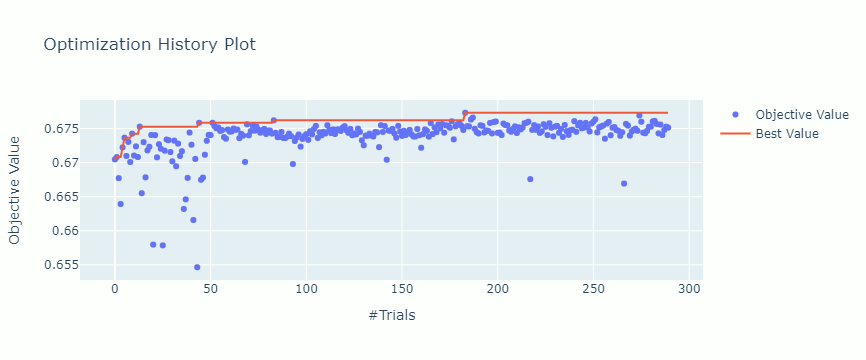

In [45]:
# history
optuna.visualization.plot_optimization_history(study)

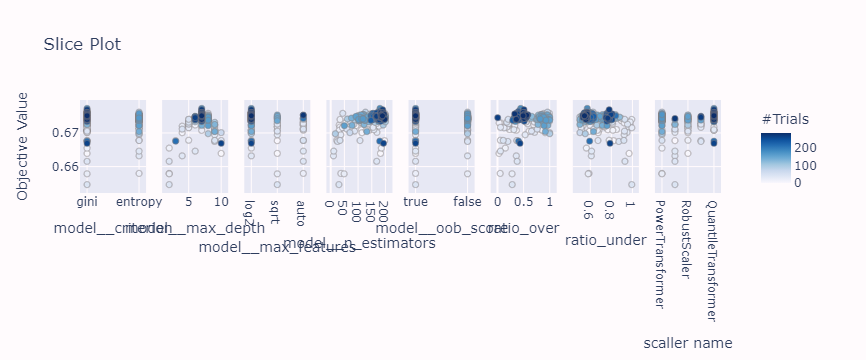

In [46]:
# Visualize individual hyperparameters as slice plot.
optuna.visualization.plot_slice(study)

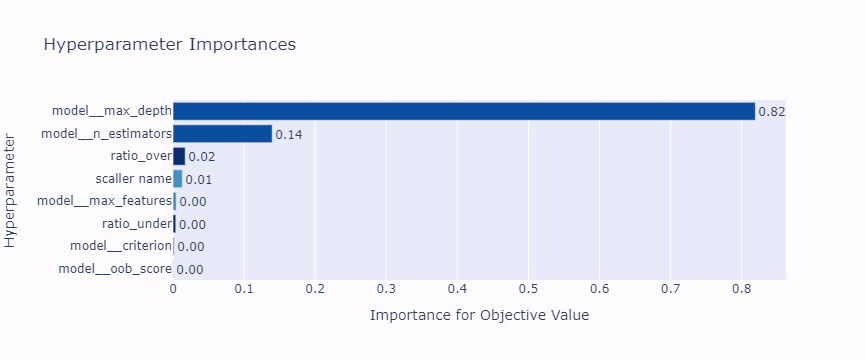

In [47]:
# Visualize parameter importances. 
optuna.visualization.plot_param_importances(study)

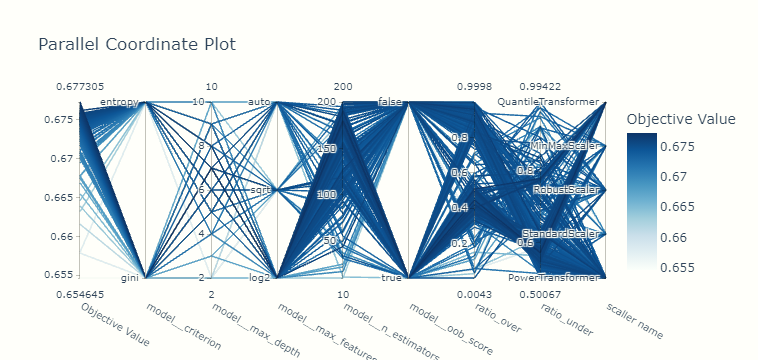

In [48]:
# Space search visualisation
optuna.visualization.plot_parallel_coordinate(study)

In [49]:
# Delete the temporary cache before exiting
# memory.clear(warn=False)
# rmtree(location)

## Meilleure solution

In [50]:
# Load best params from last search from file
# study=joblib.load(file_name)
best = study.best_params

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6773052025674776
  Params: 
    ratio_over: 0.44477364180855467
    ratio_under: 0.5713605874395502
    scaller name: QuantileTransformer
    model__max_depth: 7
    model__n_estimators: 180
    model__criterion: gini
    model__max_features: log2
    model__oob_score: True


Class balance on fitting model step : Counter({0: 91840, 1: 13091})
TRAIN
               precision    recall  f1-score   support

           0       0.96      0.71      0.82    122457
           1       0.17      0.68      0.27     10473

    accuracy                           0.71    132930
   macro avg       0.57      0.70      0.55    132930
weighted avg       0.90      0.71      0.78    132930

 Scores  on train : {'COST': 0.6773052025674776, 'AUC': 0.7372682743362089}
TEST
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     30615
           1       0.16      0.63      0.25      2618

    accuracy                           0.70     33233
   macro avg       0.56      0.67      0.53     33233
weighted avg       0.89      0.70      0.77     33233

 Scores  on test : {'COST': 0.6695084732926622}


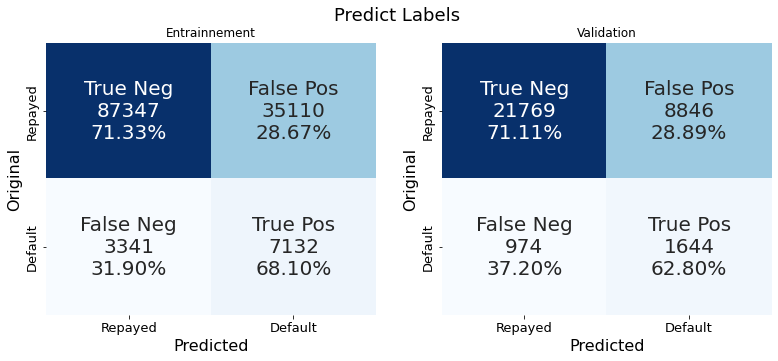

In [51]:
# print best results
# print('Best custom_score = {} for {}'.format(study.best_value,best))

# Initialize params
params = {}


# Variance space
# params['variance__threshold'] = best['variance']

# ratios for samplers
o_r = best['ratio_over']
u_r = best['ratio_under']

#over sampling
params['over__sampling_strategy'] =  ratio_initial *(1 + o_r)

# under sampling
params['under__sampling_strategy'] = ratio_initial *(1 + o_r)/( u_r)
    
# sample weight
# x = best['weight']  # MODIFIE
# params['model__class_weight'] = {0 : 1-x, 1 : x}
params['model__class_weight'] = 'balanced'

# Scaller space
scaler_name = best['scaller name']

if scaler_name == 'MinMaxScaler':
    params['scaler'] = mmx
elif scaler_name == 'StandardScaler':
    params['scaler'] =  std   
elif scaler_name == 'QuantileTransformer':
    params['scaler'] =  qt
elif scaler_name == 'RobustScaler':
    params['scaler'] =  rob
elif scaler_name == 'PowerTransformer':
    params['scaler'] =  pwt  
         
# Random Forest space       
params['model__max_depth'] = best['model__max_depth']
params['model__n_estimators'] = best['model__n_estimators']
params['model__criterion'] = best['model__criterion']
params['model__max_features'] = best['model__max_features']
# params['model__warm_start'] = best['model__warm_start']
params['model__oob_score'] = best['model__oob_score']

# set and fit with best params
pipe_optim.set_params(**params)
pipe_optim.fit(train, train_true)

# Count effective classes
print('Class balance on fitting model step : %s' % Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1]))
if LOG:
    run['Modele/[Optimisation]/Classe efectives'].log(str(Counter(pipe_samplers[0:2].fit_resample(train,train_true)[1])))


# print evaluation summary
evaluate_estimator(pipe_optim,
                   train,
                   train_true,
                   test,
                   test_true,
                   SCORER,
                   cost,
                   cv,
                   log=(LOG,run,'Modele/[Optimisation]/'))


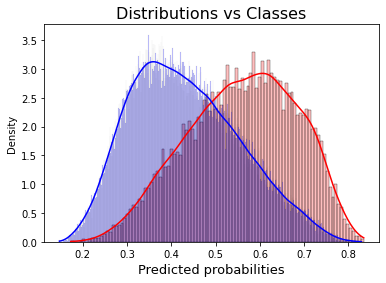

In [52]:
# Distribution of prediction probabilities versus classes
train_predicted_probas = pipe_optim.predict_proba(train)
proba_distributions(train_true,train_predicted_probas,(LOG,run,'Modele/[Optimisation]/Train'))

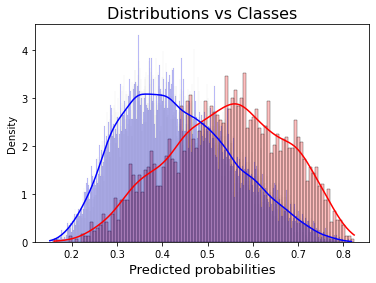

In [53]:
# Distribution of prediction probabilities versus classes
test_predicted_probas = pipe_optim.predict_proba(test)
proba_distributions(test_true,test_predicted_probas,(LOG,run,'Modele/[Optimisation]/Test'))

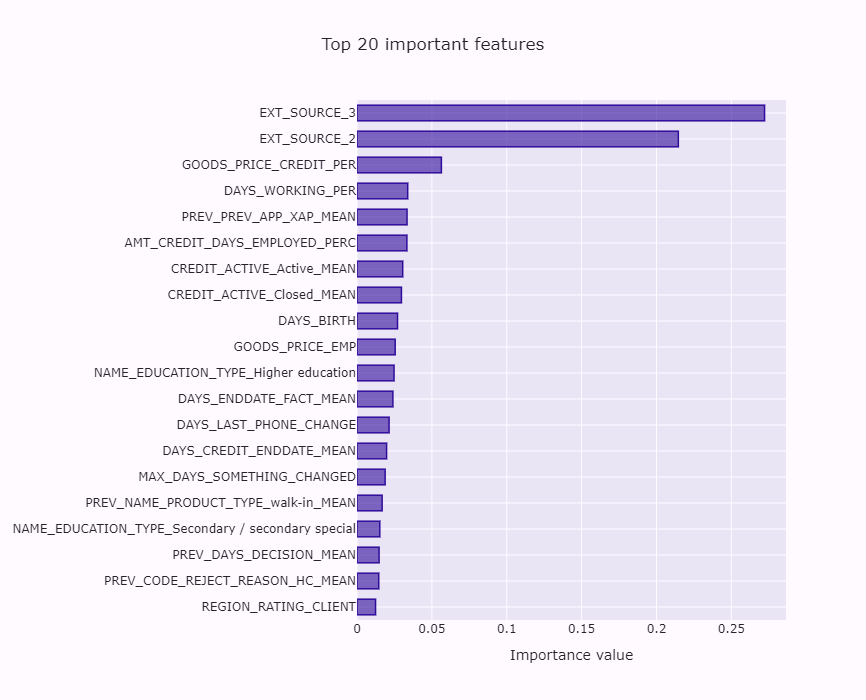

In [54]:
# Feature importance
feature_importance_plot(pipe_optim[-1].feature_importances_,train,(LOG,run,'Modele/[Optimisation]/'))

# Récapitulatif des scores

In [55]:
import ast
# List of all experiment logged to Neptune ai
steps =['[Out of bag]','[Under]','[Over]','[Balance]','[Samplers & Weight]','[Optimisation]']
# create lists to retain fetched logs
train_costs, train_aucs, test_costs, names = list(), list(), list(), list()
# ierate throught logs
for step in steps:
    names.append('Random Forest '+step)
    train_scores = ast.literal_eval(run['Modele/'+step+'/Train scores'].fetch_last())
    test_score = ast.literal_eval(run['Modele/'+step+'/Test scores'].fetch_last())
    train_costs.append(train_scores['COST'])
    train_aucs.append(train_scores['AUC'])
    test_costs.append(test_score['COST'])

# create results Data Frame
results = pd.DataFrame({'Model name'   : names,
                        'Cost on train': train_costs,
                        'Auc on train' : train_aucs,
                        'Cost on test' : test_costs,
                       }
                      )
joblib.dump(results, 'Results/rf.results')
results.style.highlight_max()

,Model name,Cost on train,Auc on train,Cost on test
0,Random Forest [Out of bag],0.501524,0.714180,0.502319
1,Random Forest [Under],0.671712,0.729986,0.670194
2,Random Forest [Over],0.505884,0.721799,0.506359
3,Random Forest [Balance],0.501000,0.717424,0.500906
4,Random Forest [Samplers & Weight],0.503753,0.720456,0.504508
5,Random Forest [Optimisation],0.677305,0.737268,0.669508


# Sauvegarde du modèle pour dasboard

modèle fitté sur toutes les données disponibles

In [56]:
# Set the filename
save_path = 'Models/'
name= 'random_forest_optimized_fitted'
file_name = name+'.mod'

# Fit on whole datas
pipe = clone(pipe_optim)
pipe.fit(features.drop('TARGET', axis=1), features.TARGET)

# Write on disk
joblib.dump(pipe, save_path+file_name, compress=('lzma',3))

if LOG:
    run['Best fitted model on all features jobilb'].upload(File(save_path+file_name))

In [57]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.


All 2 operations synced, thanks for waiting!
